In [ ]:
!pip install -U datasets transformers sentencepiece wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wandb login

wandb: Currently logged in as: _meeni_batch_. Use `wandb login --relogin` to force relogin


In [ ]:
import torch
import wandb
from torch.utils.data import DataLoader
from torch.optim import AdamW, RAdam, SGD
from transformers import get_linear_schedule_with_warmup, DebertaV2TokenizerFast, DebertaV2ForQuestionAnswering, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
from tqdm import tqdm
import os
import json
import random
import numpy as np

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the tokenizer and model
tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v3-base')
model = DebertaV2ForQuestionAnswering.from_pretrained('microsoft/deberta-v3-base')
model.gradient_checkpointing_enable()
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the full SQuAD dataset
dataset = load_dataset('squad')

# Use the full training and validation sets
train_dataset = dataset['train']
val_dataset = dataset['validation']

# # For model development
# train_dataset = dataset['train'].train_test_split(train_size=10000)['train']
# val_dataset = dataset['validation'].train_test_split(train_size=1000)['train']

best_model_path = '/content/drive/MyDrive/models/deberta_squad_adamw_best_model_full.pt'

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/debert

In [ ]:
# Hyperparameters
BATCH_SIZE = 20
NUM_EPOCHS = 10  # Using early stopping
LEARNING_RATE = 2e-5  # Increased learning rate from 1e-6
WEIGHT_DECAY = 0.001
MAX_LEN = 512

# Function to prepare features

def prepare_train_features(examples):

    # Tokenize the questions and contexts
    tokenized_inputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=512,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized_inputs.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_inputs.pop("offset_mapping")

    tokenized_inputs["start_positions"] = []
    tokenized_inputs["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_inputs["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_inputs.sequence_ids(i)

        sample_index = sample_mapping[i]
        answer = examples["answers"][sample_index]
        if len(answer["answer_start"]) == 0:
            tokenized_inputs["start_positions"].append(cls_index)
            tokenized_inputs["end_positions"].append(cls_index)
        else:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_inputs["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_inputs["end_positions"].append(token_end_index + 1)
            else:
                tokenized_inputs["start_positions"].append(cls_index)
                tokenized_inputs["end_positions"].append(cls_index)

    return tokenized_inputs

# Apply the function to the datasets
tokenized_train = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(prepare_train_features, batched=True, remove_columns=val_dataset.column_names)

# Set format to PyTorch tensors
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer, return_tensors='pt')

# Create DataLoaders with increased batch size
train_loader = DataLoader(tokenized_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(tokenized_val, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
# Clear cache
torch.cuda.empty_cache()

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * 0.1)  # 10% of total steps for warmup

# Initialize W&B run
wandb.init(project="deberta_squad_training", config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "weight_decay": WEIGHT_DECAY,
    "max_seq_length": MAX_LEN,
    "warmup_steps": warmup_steps
})

# Set W&B Configurations
config = wandb.config
config.warmup_steps = warmup_steps
max_lr = config.learning_rate

# Use PyTorch's AdamW optimizer with adjusted weight decay
optimizer = AdamW(model.parameters(), lr=max_lr, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Early stopping parameters
patience = 2
best_val_loss = float('inf')
patience_counter = 0

# Function to compute EM and F1 score during validation
def compute_metrics(start_pred, end_pred, start_true, end_true):
    em = 0
    f1 = 0
    n = len(start_pred)
    for i in range(n):
        pred_span = set(range(start_pred[i], end_pred[i] + 1))
        true_span = set(range(start_true[i], end_true[i] + 1))

        # Exact Match
        em += int(pred_span == true_span)

        # F1 Score
        overlap = pred_span & true_span
        if len(overlap) > 0:
            precision = len(overlap) / len(pred_span)
            recall = len(overlap) / len(true_span)
            f1 += 2 * (precision * recall) / (precision + recall)

    em = em / n
    f1 = f1 / n
    return em, f1

# Training loop
train_losses = []
val_losses = []
f1_scores = []

# Inititialze GradScalar for mixed precision training
scaler = torch.amp.GradScaler('cuda')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=True)

    for batch_idx, batch in enumerate(progress_bar):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          start_positions = batch['start_positions'].to(device)
          end_positions = batch['end_positions'].to(device)

          # Zero parameter gradients
          optimizer.zero_grad()

          with torch.amp.autocast('cuda'):

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)

            loss = outputs.loss

          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

          scheduler.step()

          train_loss += loss.item()

          # Update progress bar
          progress_bar.set_postfix(avg_loss=train_loss / (batch_idx + 1))

          # Log training updates
          if (batch_idx + 1) % 100 == 0:
            wandb.log({"train_loss_step": train_loss/(batch_idx + 1)})

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    em_score = 0.0
    f1_score = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)

            loss = outputs.loss
            val_loss += loss.item()

            # Compute Metrics
            start_preds = outputs.start_logits.argmax(dim=-1).cpu().numpy()
            end_preds = outputs.end_logits.argmax(dim=-1).cpu().numpy()

            start_true = start_positions.cpu().numpy()
            end_true = end_positions.cpu().numpy()

            em, f1 = compute_metrics(start_preds, end_preds, start_true, end_true)
            em_score += em
            f1_score += f1

    avg_val_loss = val_loss / len(val_loader)
    avg_em = em_score / len(val_loader)
    avg_f1 = f1_score / len(val_loader)

    val_losses.append(avg_val_loss)
    f1_scores.append(avg_f1)

    wandb.log({"epoch":epoch + 1,
               "train_loss":avg_train_loss,
               "val_loss":avg_val_loss,
               "EM":avg_em,
               "F1":avg_f1})

    print(f"Validation Loss: {avg_val_loss:.4f}, EM: {avg_em:.4f}, F1: {avg_f1:.4f}")

    # Early Stopping and Model Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f"Saving new best model at epoch {epoch + 1}")
        model.save_pretrained(best_model_path)
        patience_counter = 0
        # Save the model checkpoint to W&B
        wandb.save(os.path.join(best_model_path, '*'))
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
wandb.finish()

Epoch 1/10 Training:   0%|          | 0/4385 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Epoch 1/10 Training: 100%|██████████| 4385/4385 [1:45:12<00:00,  1.44s/it, avg_loss=1.55]


Validation Loss: 0.8541, EM: 0.6331, F1: 0.8202
Saving new best model at epoch 1


wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


Epoch 1/10, Training Loss: 1.5532, Validation Loss: 0.8541


Epoch 2/10 Training: 100%|██████████| 4385/4385 [1:45:07<00:00,  1.44s/it, avg_loss=0.732]


Validation Loss: 0.7639, EM: 0.6486, F1: 0.8289
Saving new best model at epoch 2
Epoch 2/10, Training Loss: 0.7322, Validation Loss: 0.7639


Epoch 3/10 Training: 100%|██████████| 4385/4385 [1:45:04<00:00,  1.44s/it, avg_loss=0.566]


Validation Loss: 0.7924, EM: 0.6517, F1: 0.8346
Epoch 3/10, Training Loss: 0.5660, Validation Loss: 0.7924


Epoch 4/10 Training: 100%|██████████| 4385/4385 [1:45:01<00:00,  1.44s/it, avg_loss=0.45]


Validation Loss: 0.8904, EM: 0.6507, F1: 0.8307
Early stopping at epoch 4


EM,▁▇██
F1,▁▅█▆
epoch,▁▃▆█
train_loss,█▃▂▁
train_loss_step,█▆▅▅▄▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁▃█
EM,0.65067
F1,0.83074
epoch,4
train_loss,0.44951
train_loss_step,0.44992


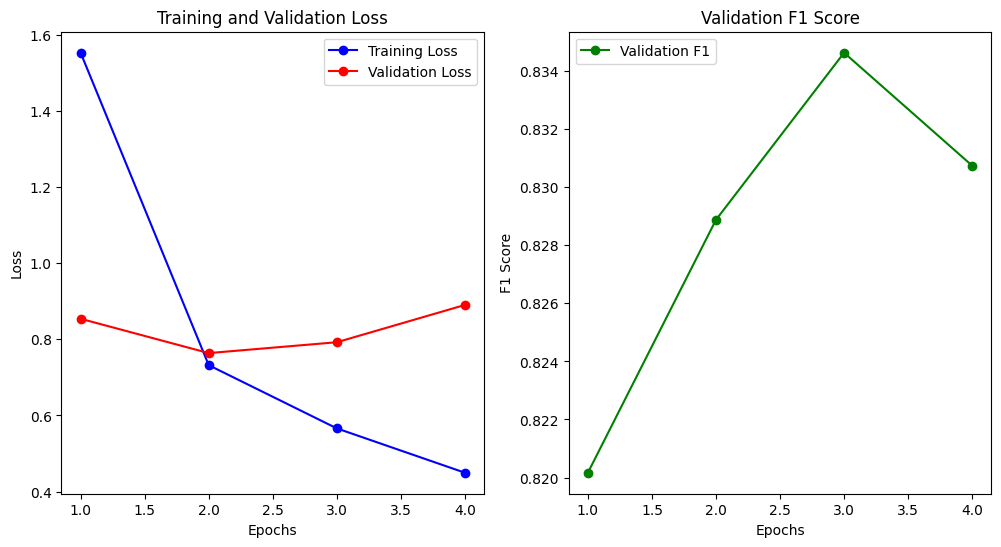

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, f1_scores):
    epochs = range(1, len(train_losses) + 1)

    # Plotting Training and Validation Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_scores, 'go-', label='Validation F1')
    plt.title('Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()

# Call this function after training is complete
plot_learning_curves(train_losses, val_losses, f1_scores)

In [ ]:
# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/models/deberta_squad_full")

In [ ]:
# Attention Analysis
from transformers import DebertaV2TokenizerFast, DebertaV2ForQuestionAnswering
import torch

model_path = '/content/drive/MyDrive/models/deberta_squad_adamw_best_model_full.pt'
model = DebertaV2ForQuestionAnswering.from_pretrained(model_path)
tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v3-base')
model_weights = model.state_dict()

In [ ]:
question = "When did John go to the store?"
response = "John went to the store at noon."

inputs = tokenizer.encode_plus(question, response, return_tensors='pt',  add_special_tokens=True)
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

In [ ]:
print(len(attentions))
attentions[0].size(), attentions[-1].size()

12


(torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]))

In [ ]:
import numpy as np

# examine the outputs
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# apply softmax
start_probs = torch.softmax(start_logits, dim=-1)
end_probs = torch.softmax(end_logits, dim=-1)

# Find the tokens with the highest start and end probabilities
start_index = torch.argmax(start_probs)
end_index = torch.argmax(end_probs)

# convert indices to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]) # the context or "response"

# extract the answer tokens and combine them into a string
answer_tokens = tokens[start_index: end_index + 1]
answer = " ".join(answer_tokens)

# Inducer prediction
num_layers = len(attentions)
num_heads = attentions[0].size(1)

question_end_index = tokens.index('[SEP]')
question_indices = range(1, question_end_index)
summed_attentions = np.zeros(len(tokens[:question_end_index]))

# Sum the attentions
for layer in range(num_layers):
    for head in range(num_heads):
        summed_attentions += attentions[layer][0, head, start_index:end_index + 1, :question_end_index].sum(dim=0).detach().numpy()
    summed_attentions /= np.sum(summed_attentions) # normalize over head

# Define a set of special tokens we want to exclude
special_tokens = {'[CLS]', '[SEP]', '[PAD]', '[UNK]'}

# Pair tokens with their summed attention, excluding special tokens
token_attention_pairs = [(token, summed_attentions[i]) for i, token in enumerate(tokens[:question_end_index]) if token not in special_tokens]

# Sort by attention, descending
token_attention_pairs.sort(key=lambda x: x[1], reverse=True)

# Since DeBERTa uses SentencePiece, it may have split words into subwords.
# We will have to merge them back together by removing the leading spaces (indicated by "▁") and combining subwords.
answer = answer.replace(' ▁', ' ').replace('▁', '  ').strip()
attended_token = token_attention_pairs[0][0].replace(' ▁', ' ').replace('▁', '  ').strip()

# find induction tokens
attended_tokens = []
for token in token_attention_pairs:
    attended_tokens.append(token[0])


# deprocess attended tokens
all_attended_tokens = " ".join([token.replace(' ▁', ' ').replace('▁', '  ').strip() for token in attended_tokens])

print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Main attended token: {attended_token}")

Question: When did John go to the store?
Answer: noon
Main attended token: When


In [ ]:
token_attention_pairs

[('▁When', 0.24238292322864205),
 ('?', 0.0885940044754013),
 ('▁did', 0.05030579511763521),
 ('▁go', 0.04753553749255423),
 ('▁John', 0.03766535092028951),
 ('▁to', 0.03500793878152036),
 ('▁the', 0.015899646180058433),
 ('▁store', 0.015181720376905994)]

In [ ]:
tokens_and_attns = [val for val in [(token, summed_attentions[i]) for i, token in enumerate(tokens[:question_end_index])]]
tokens_and_attns

[('[CLS]', 0.4674270834269929),
 ('▁When', 0.24238292322864205),
 ('▁did', 0.05030579511763521),
 ('▁John', 0.03766535092028951),
 ('▁go', 0.04753553749255423),
 ('▁to', 0.03500793878152036),
 ('▁the', 0.015899646180058433),
 ('▁store', 0.015181720376905994),
 ('?', 0.0885940044754013)]

## Attention Heatmaps

* Each row in an attention matrix corresponds to a query token. The query
tokens are the tokens for which the model is calculating attention scores to decide how much focus or 'attention' to place on other tokens.
Each column in the matrix corresponds to a key token. These are the tokens that the query tokens are 'looking at' when the model is determining the attention scores.

* The values within the matrix (each cell) represent the attention score from one token to another. A higher value means that the token represented by the row is paying more attention to the token represented by the column.

* When you visualize an attention matrix using a heatmap, you're essentially visualizing how each token (each row) distributes its attention across all other tokens (each column) in the sequence.

For example:  
> If you have a sentence like "The cat sat on the mat", and you are looking at the attention matrix for the token "cat":The row for "cat" will show how much attention "cat" pays to "The", "sat", "on", "the", and "mat".
If the value in the "sat" column is high, it indicates that "cat" is strongly associated with "sat" in this particular attention pattern.

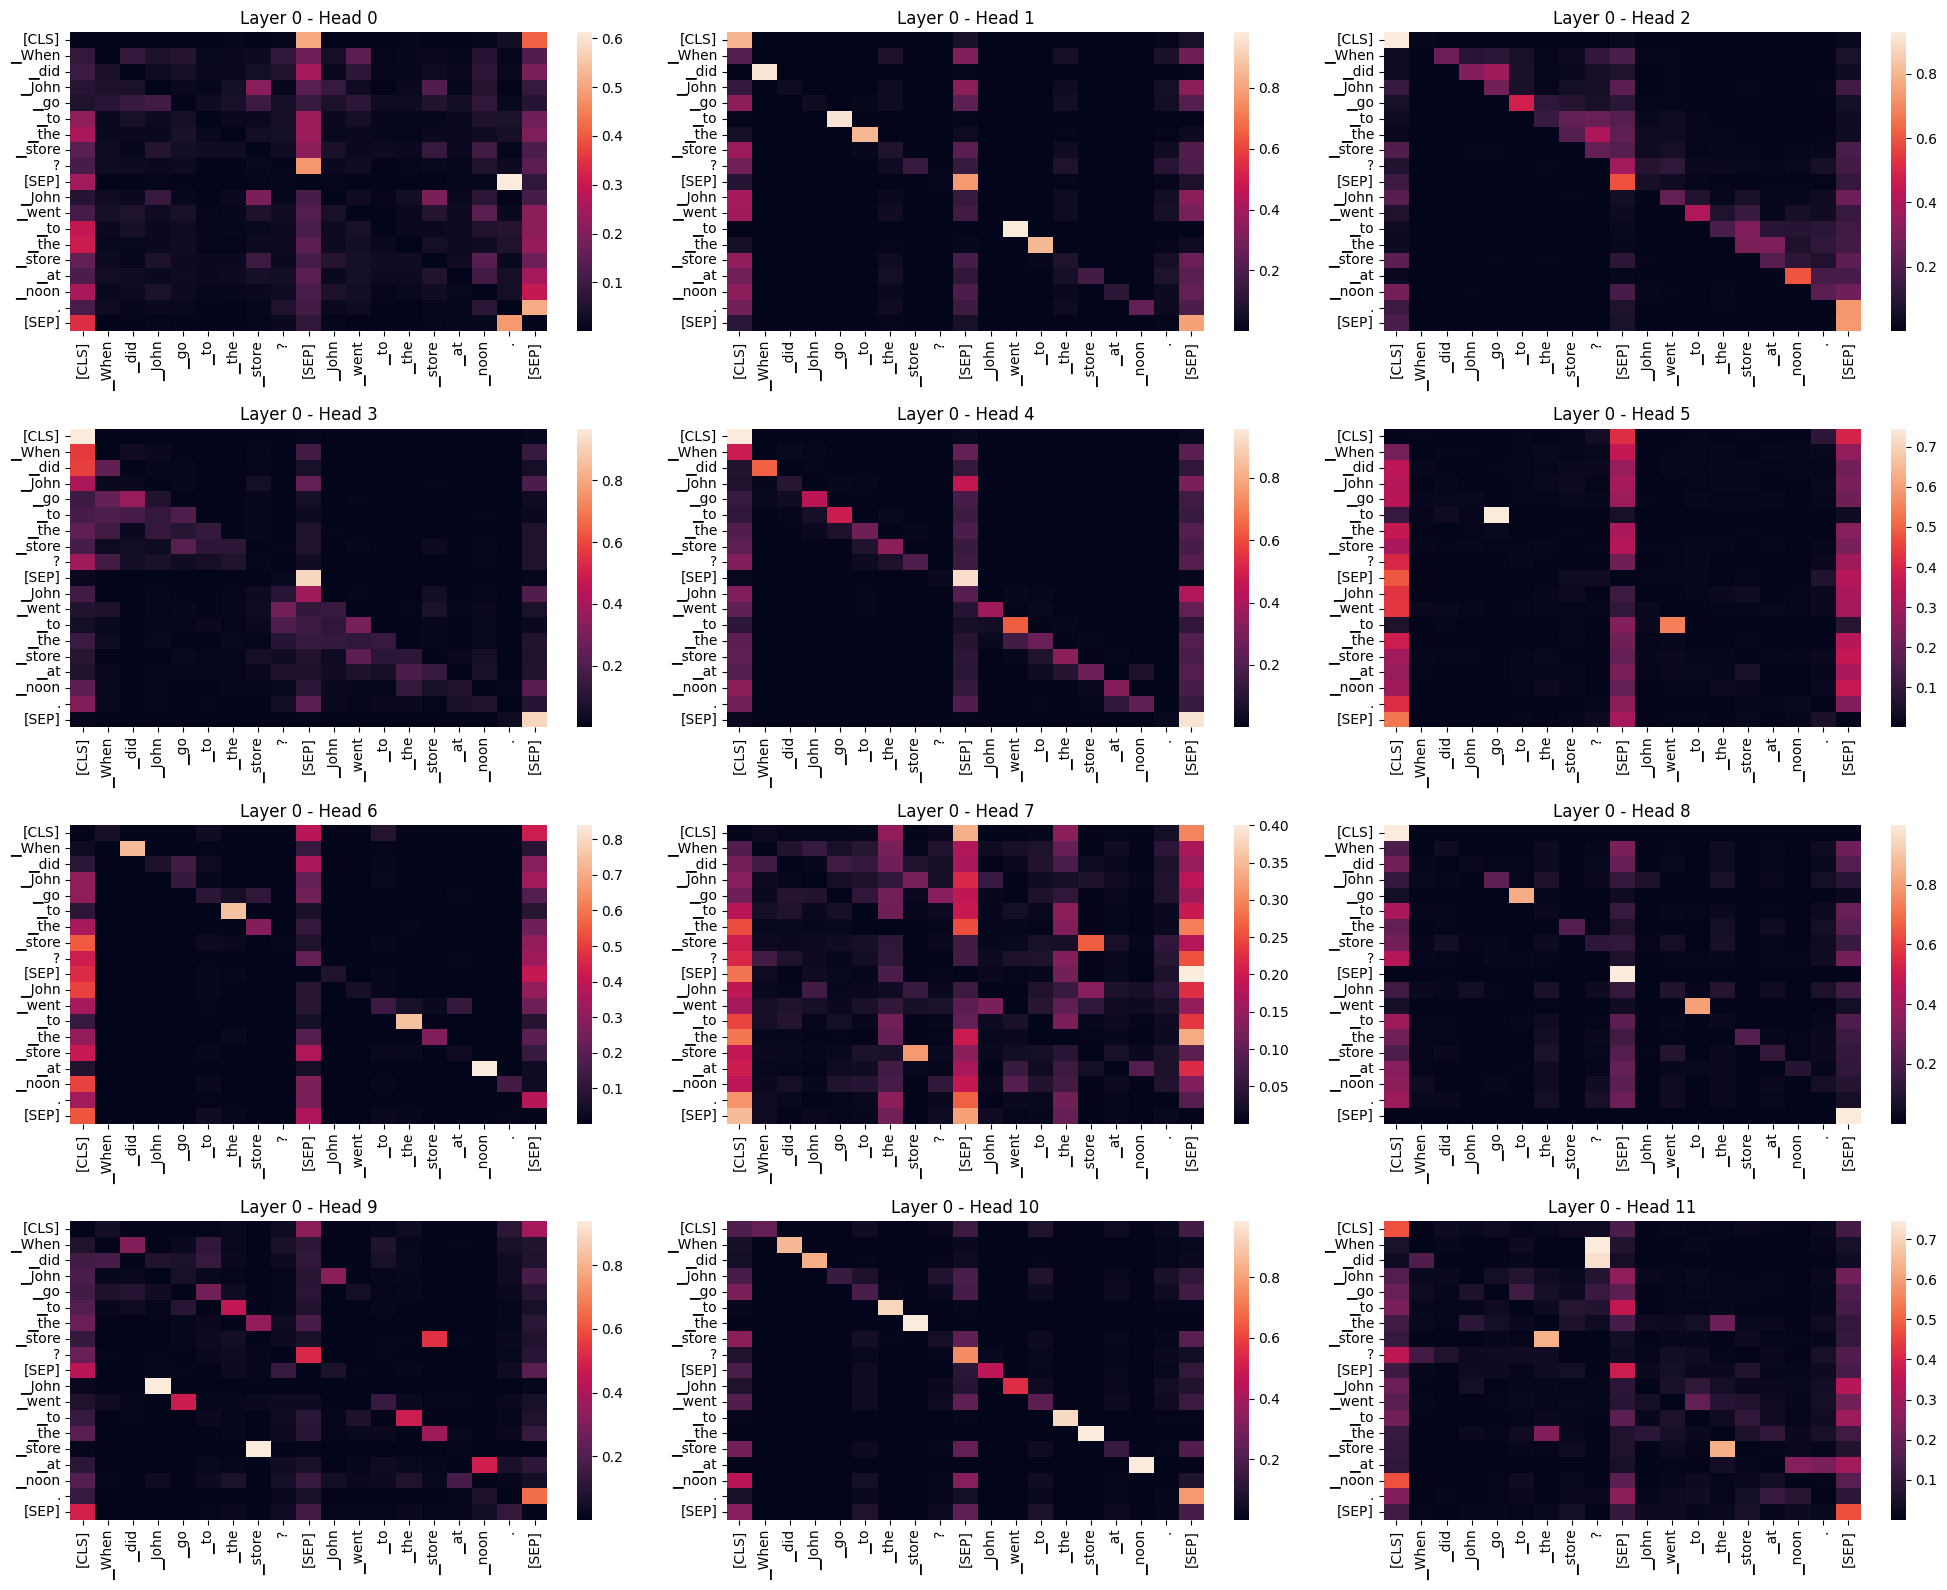

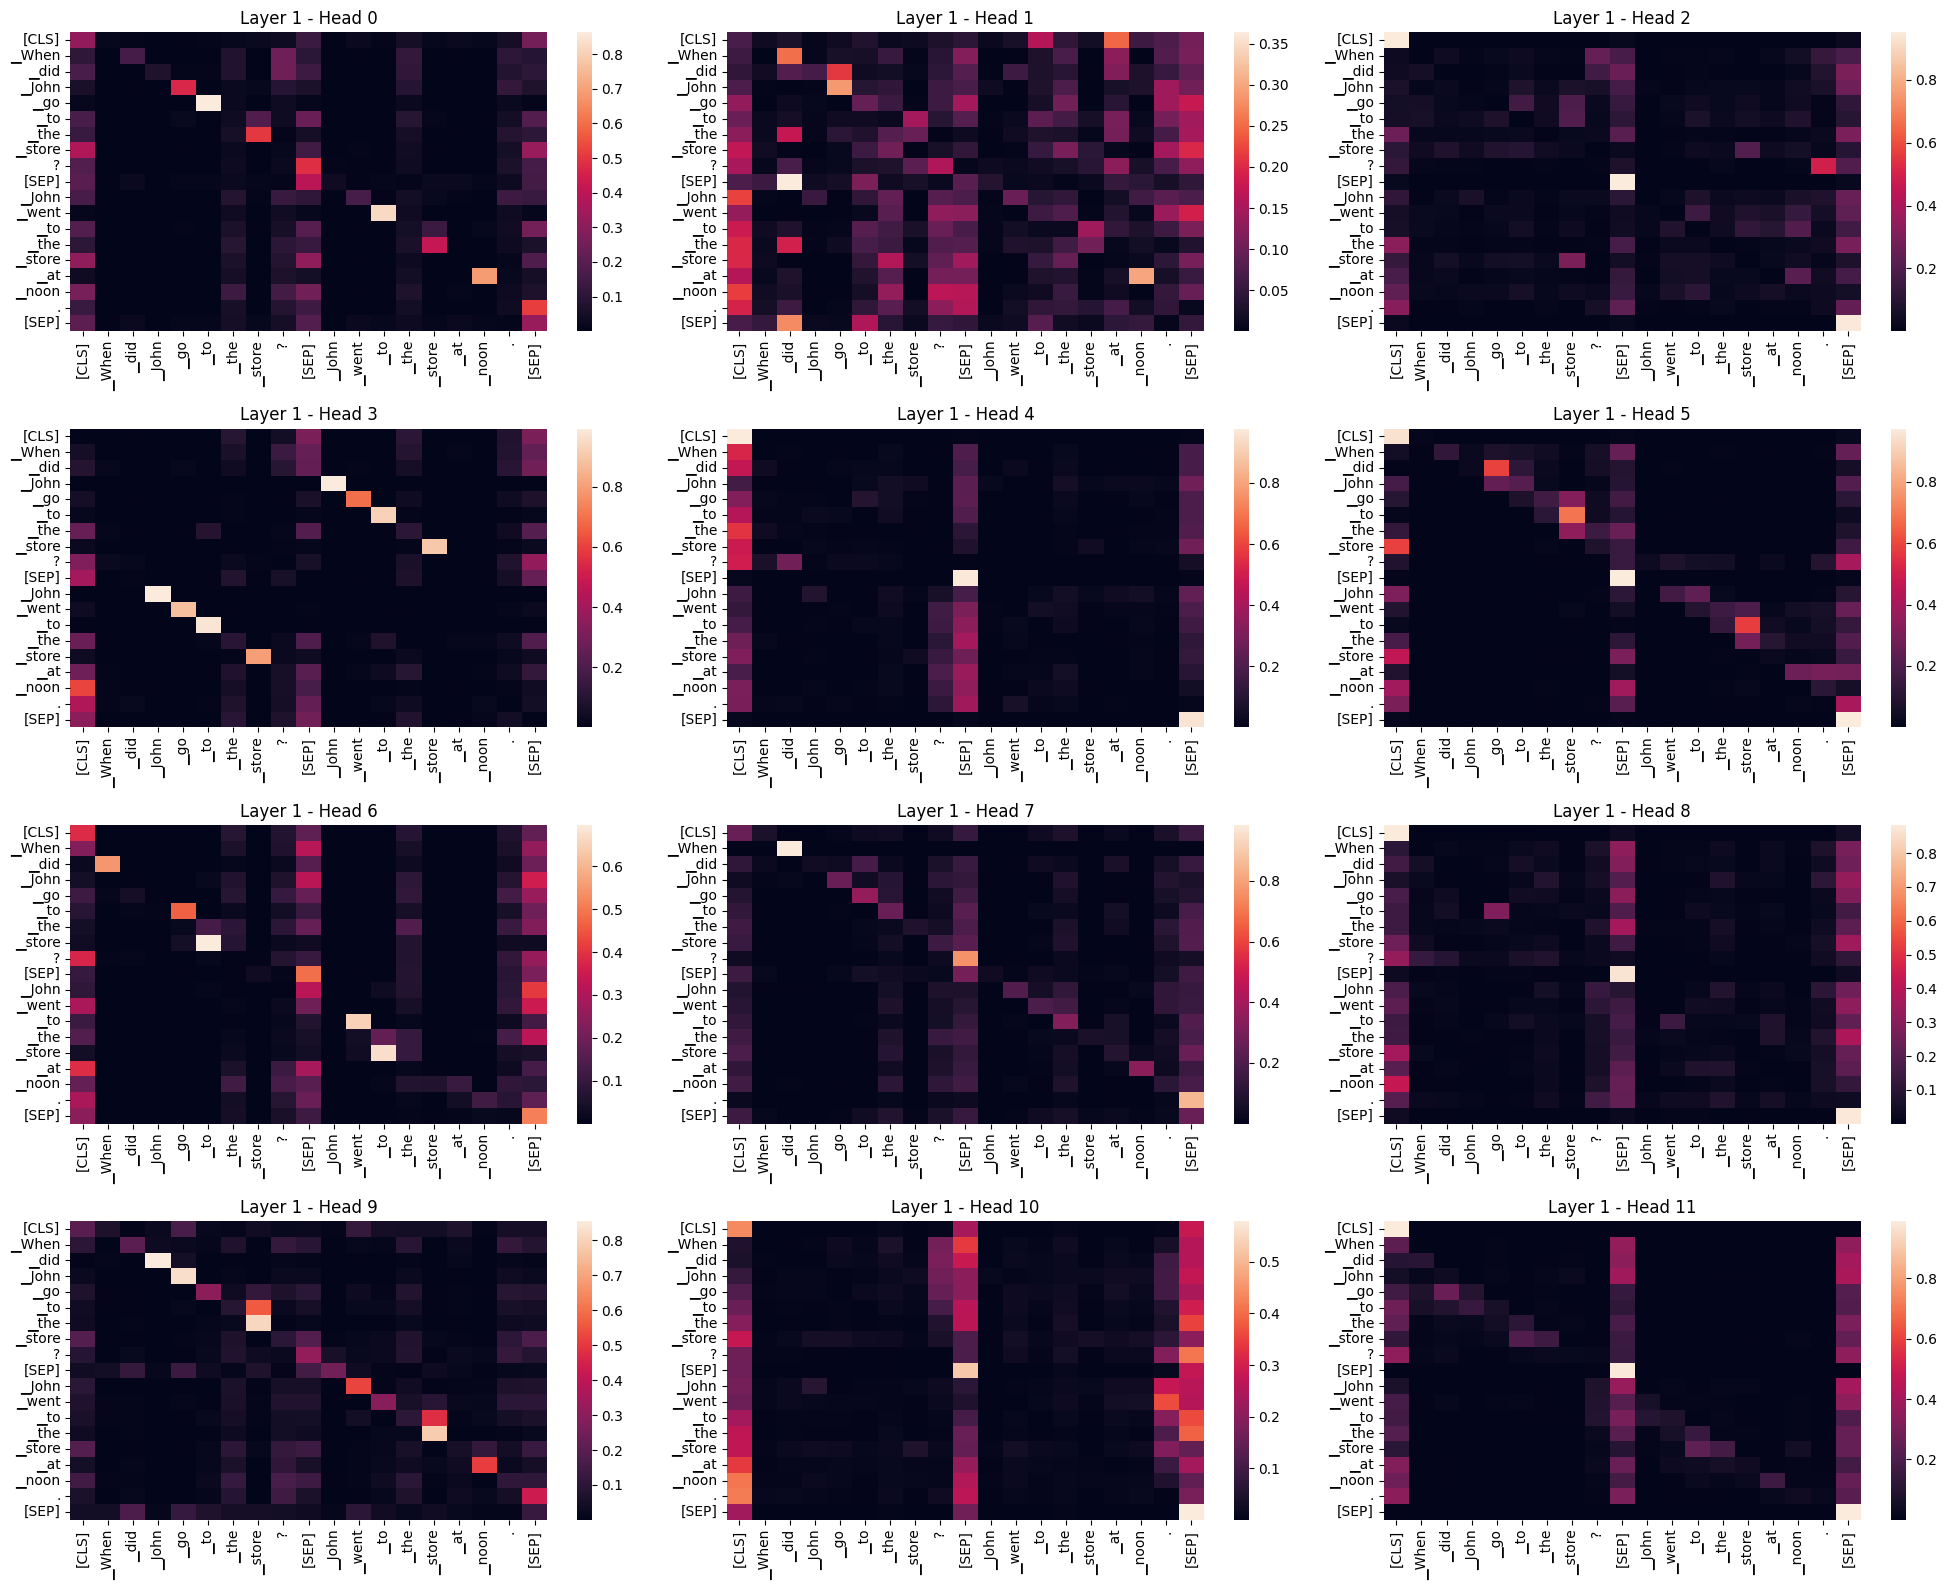

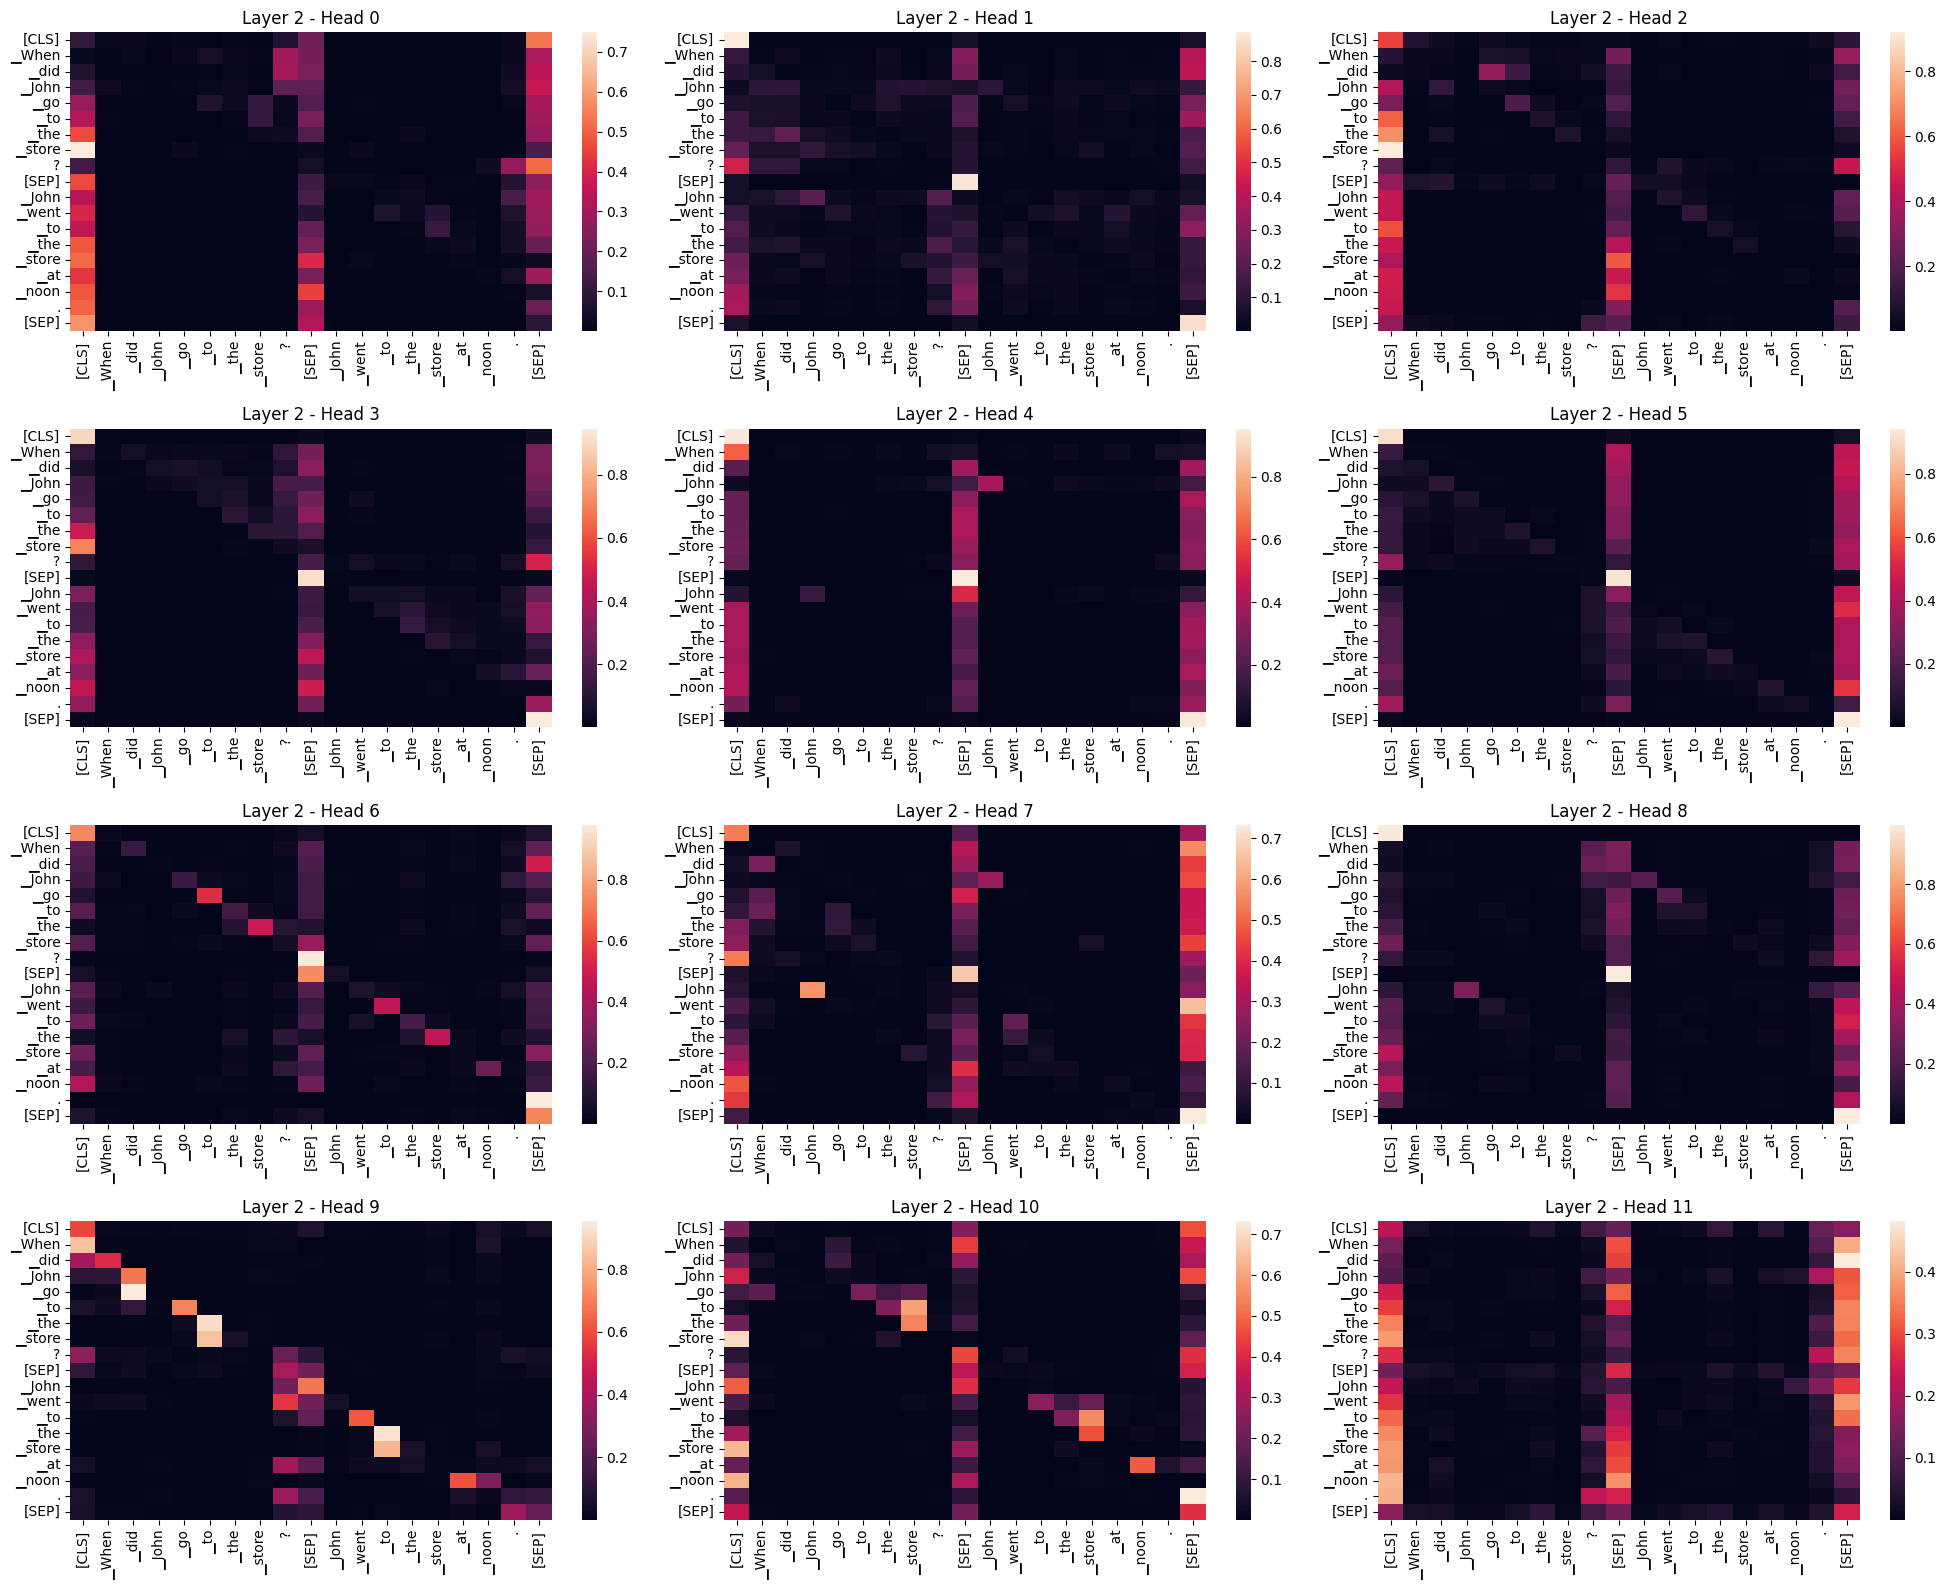

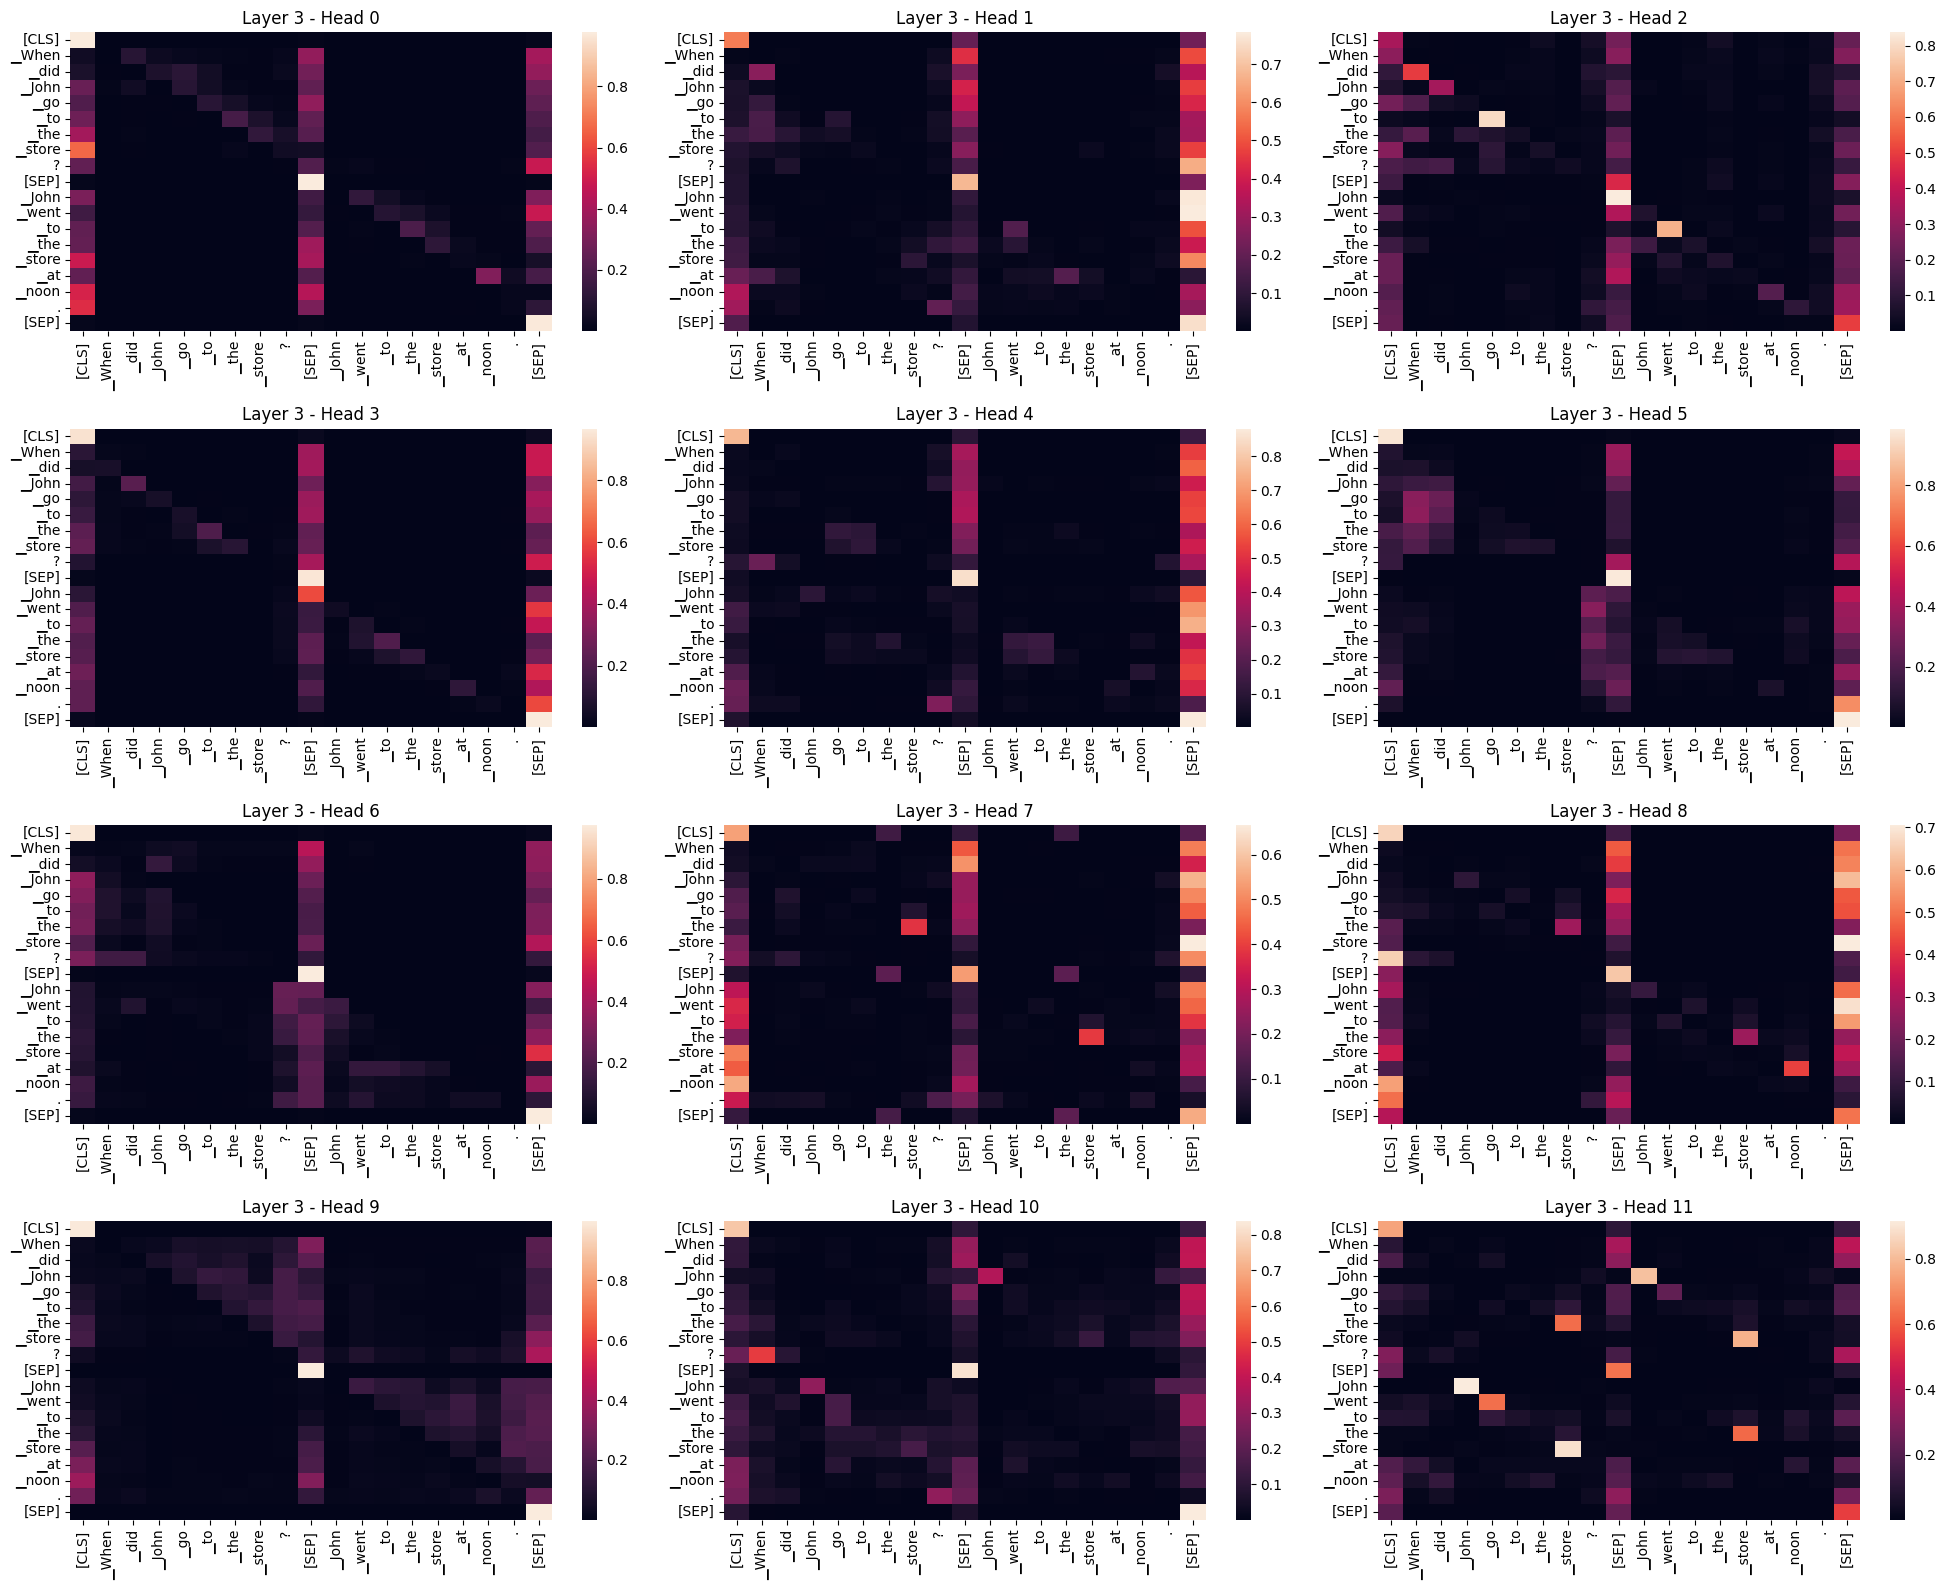

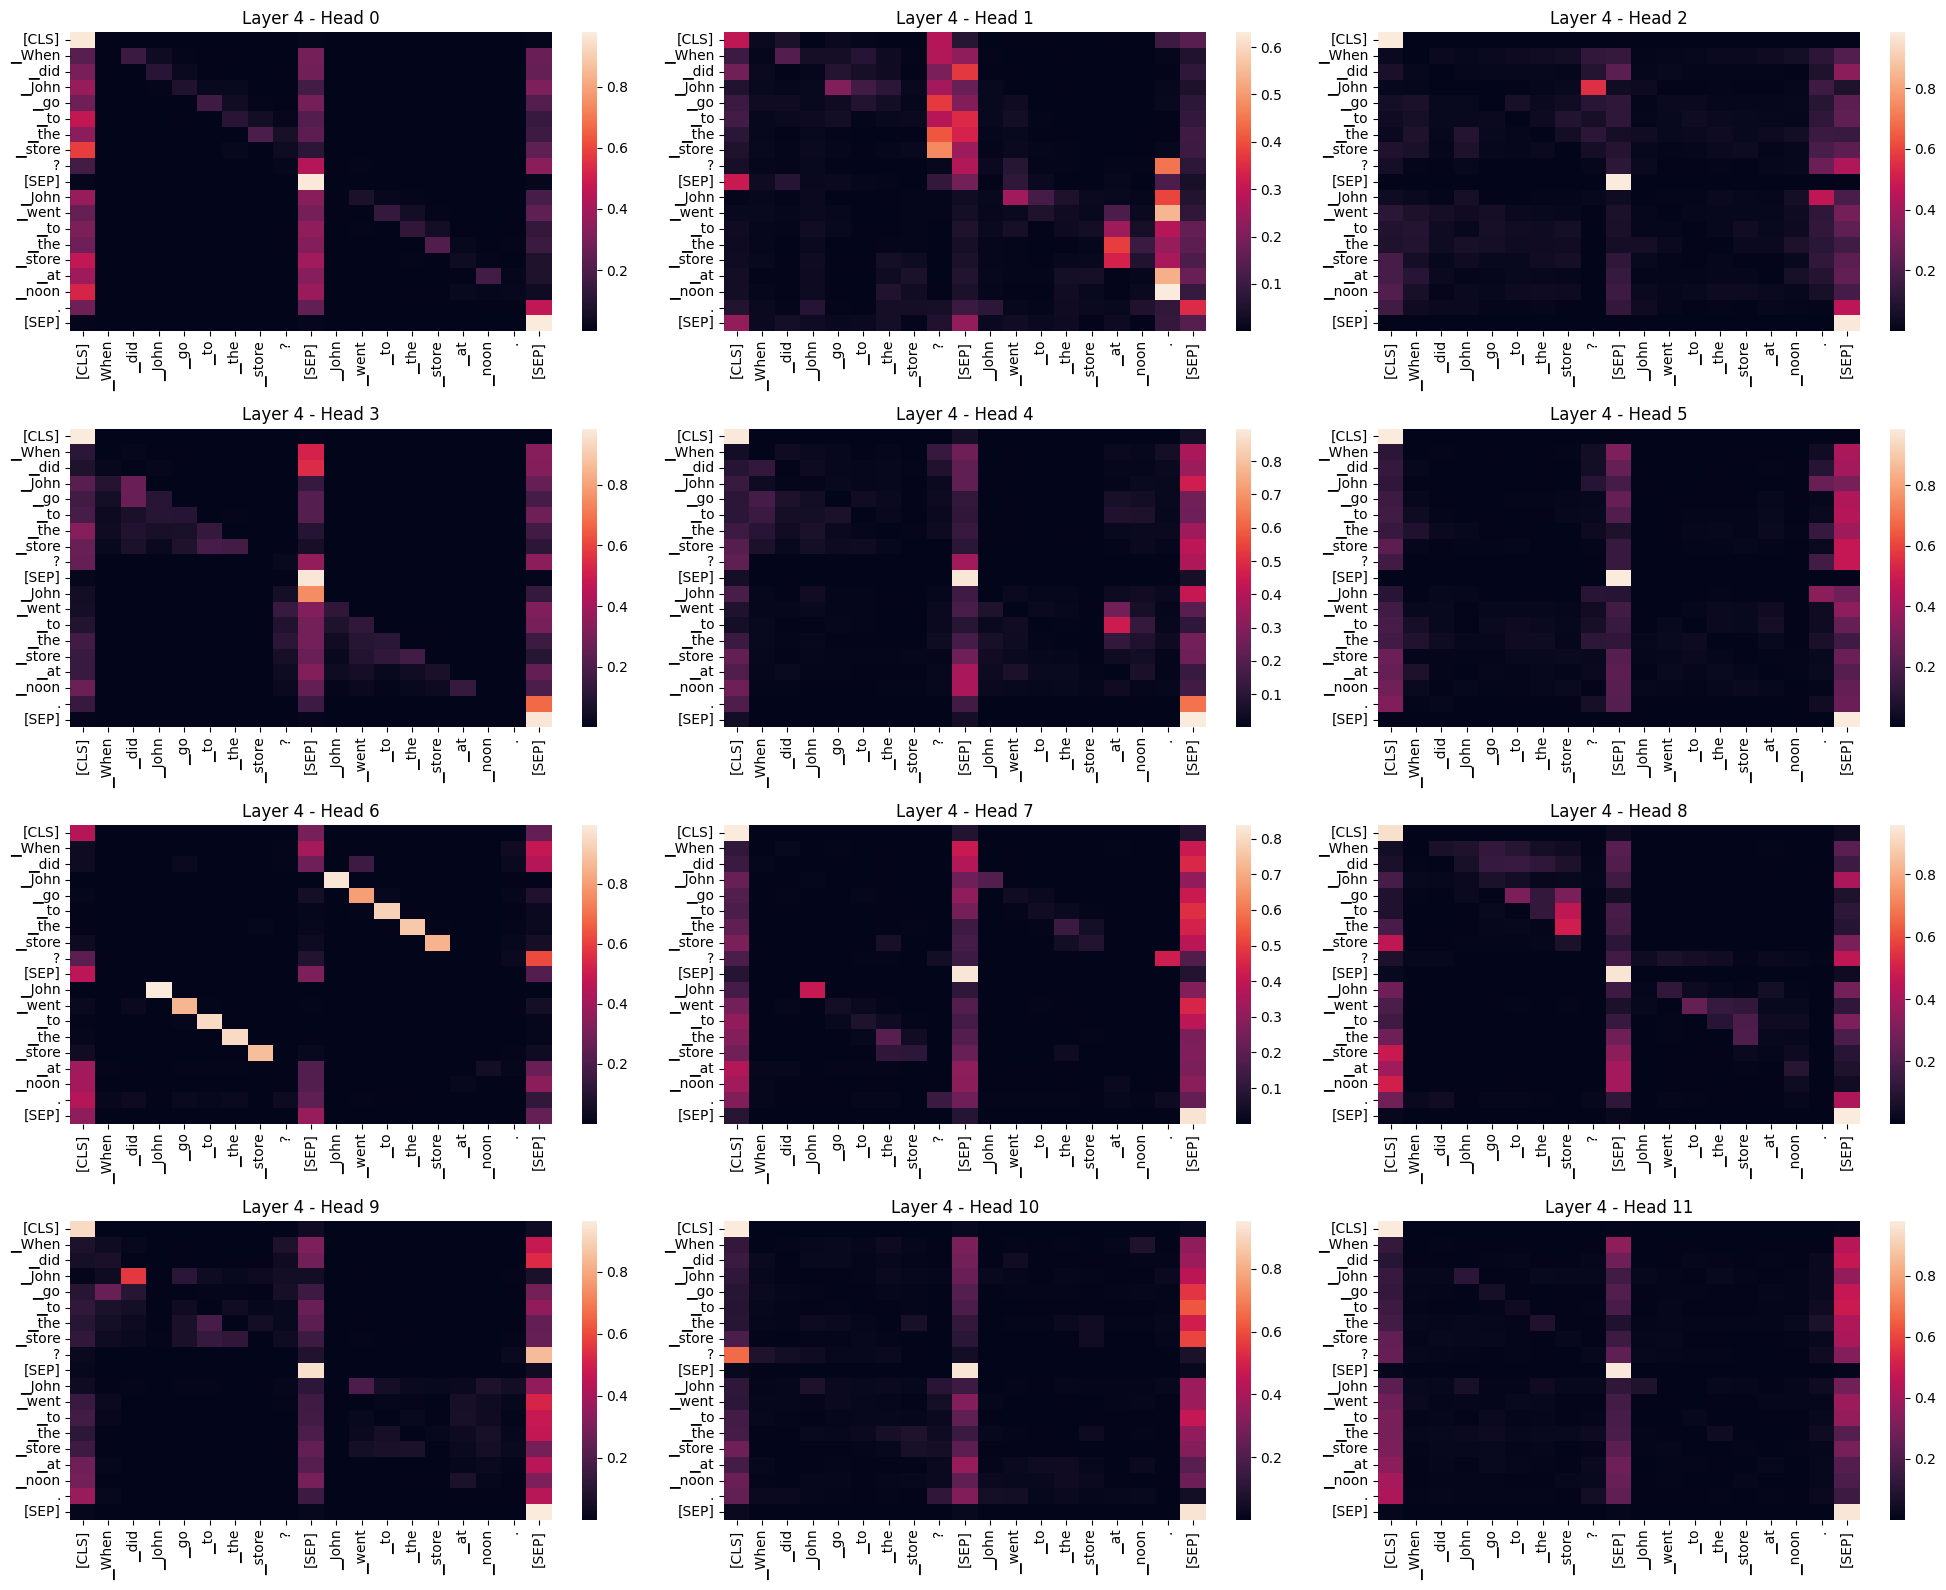

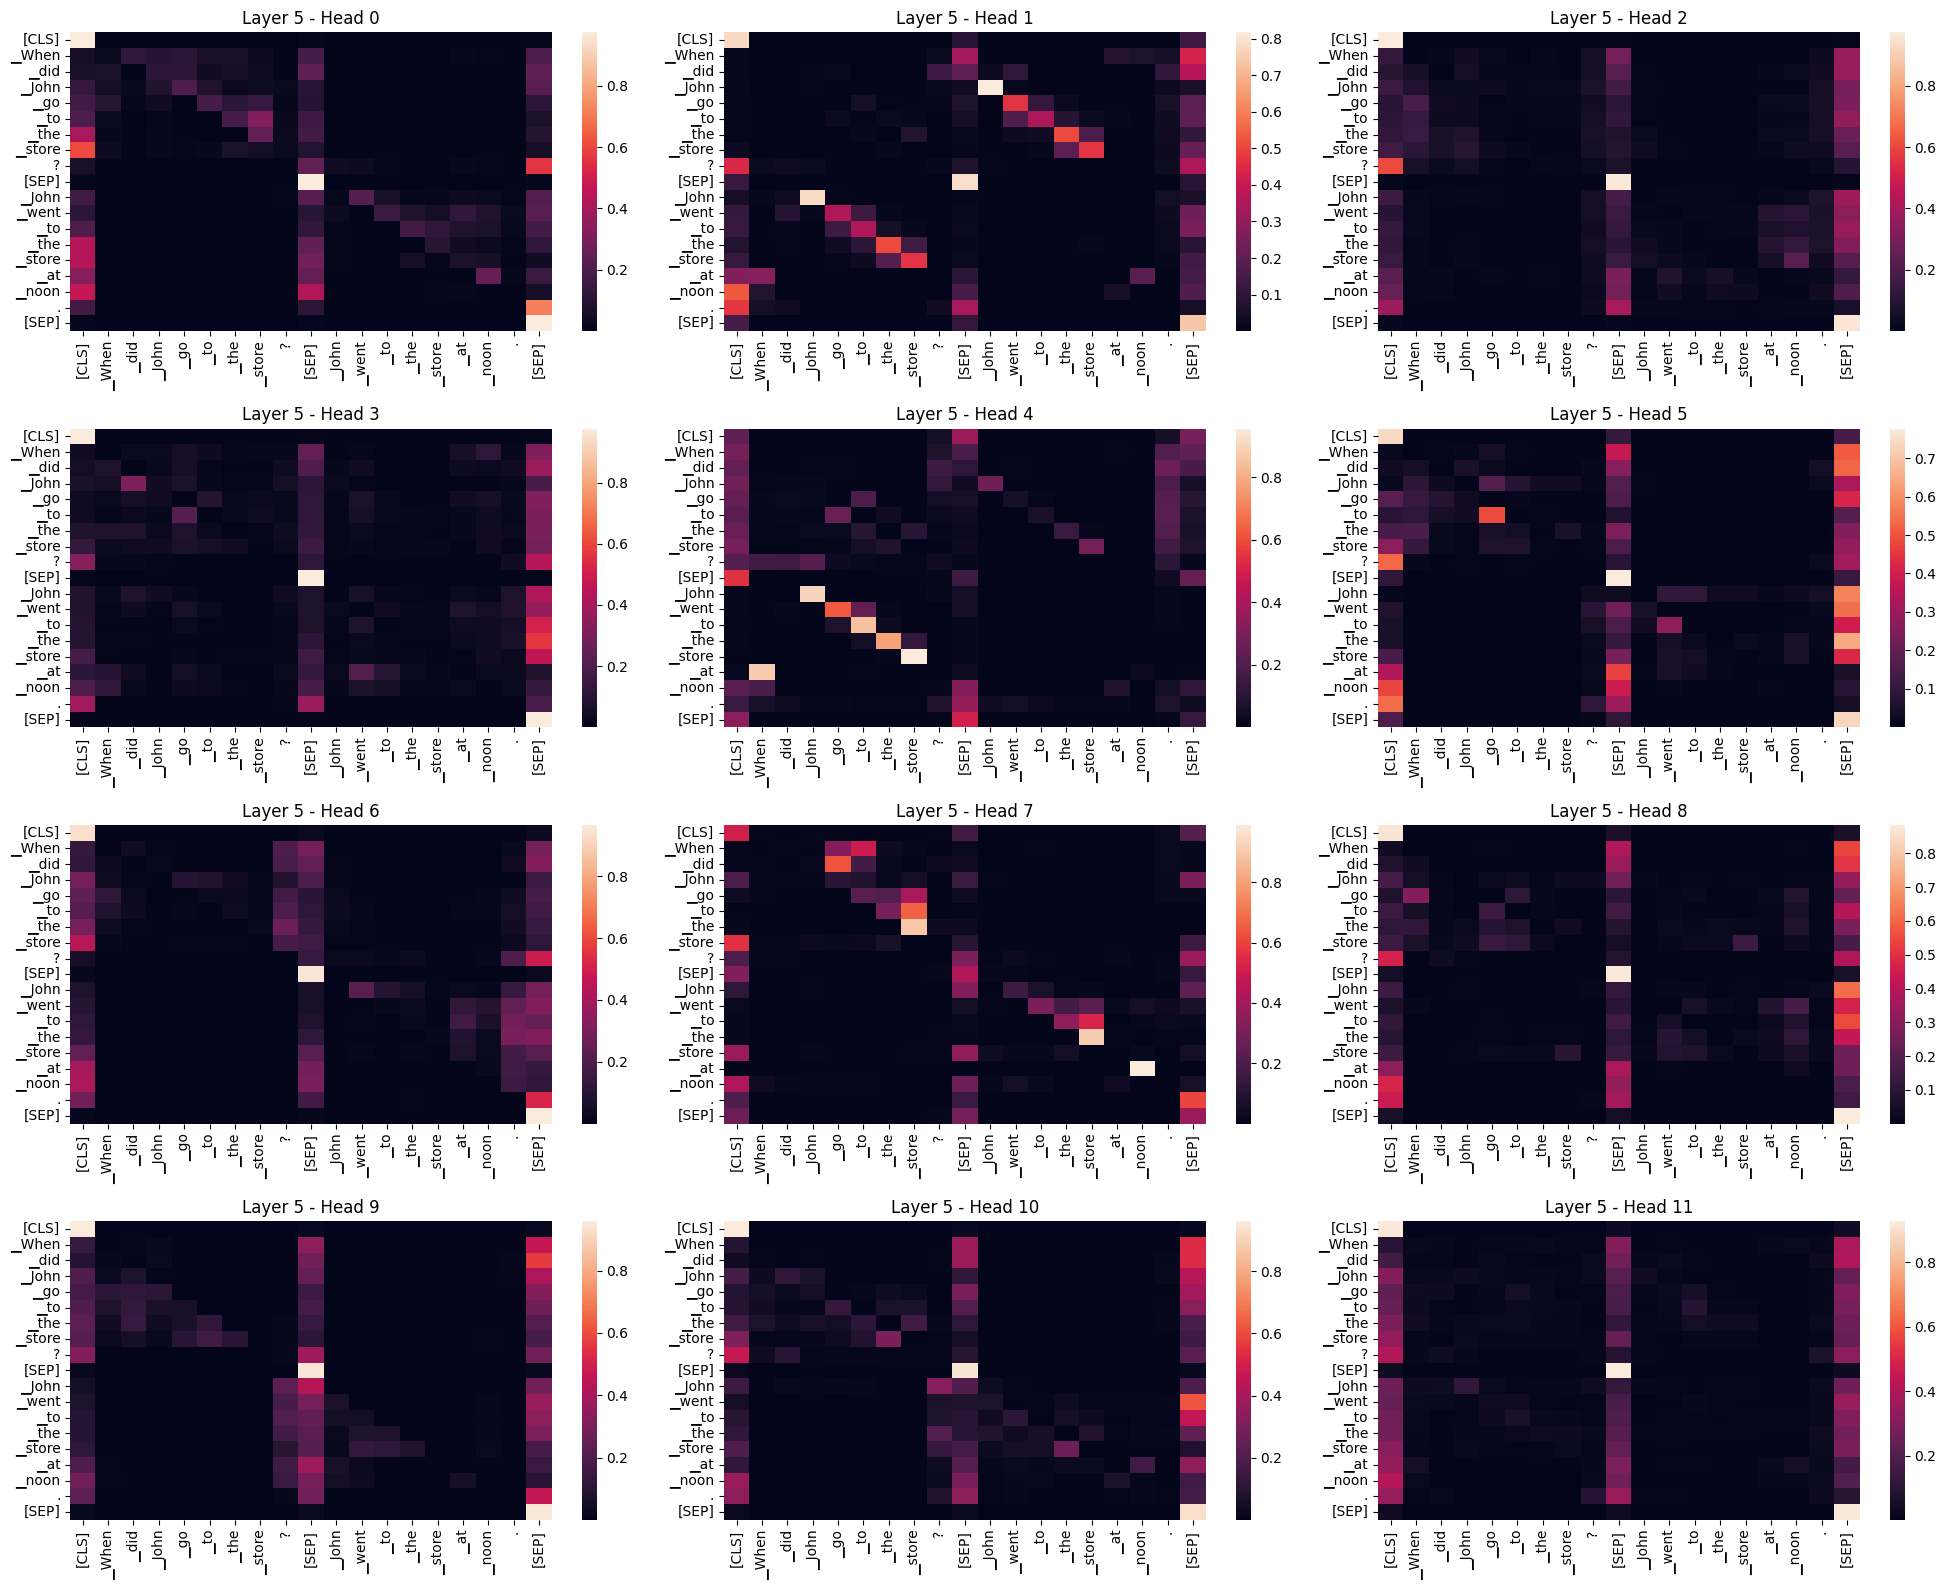

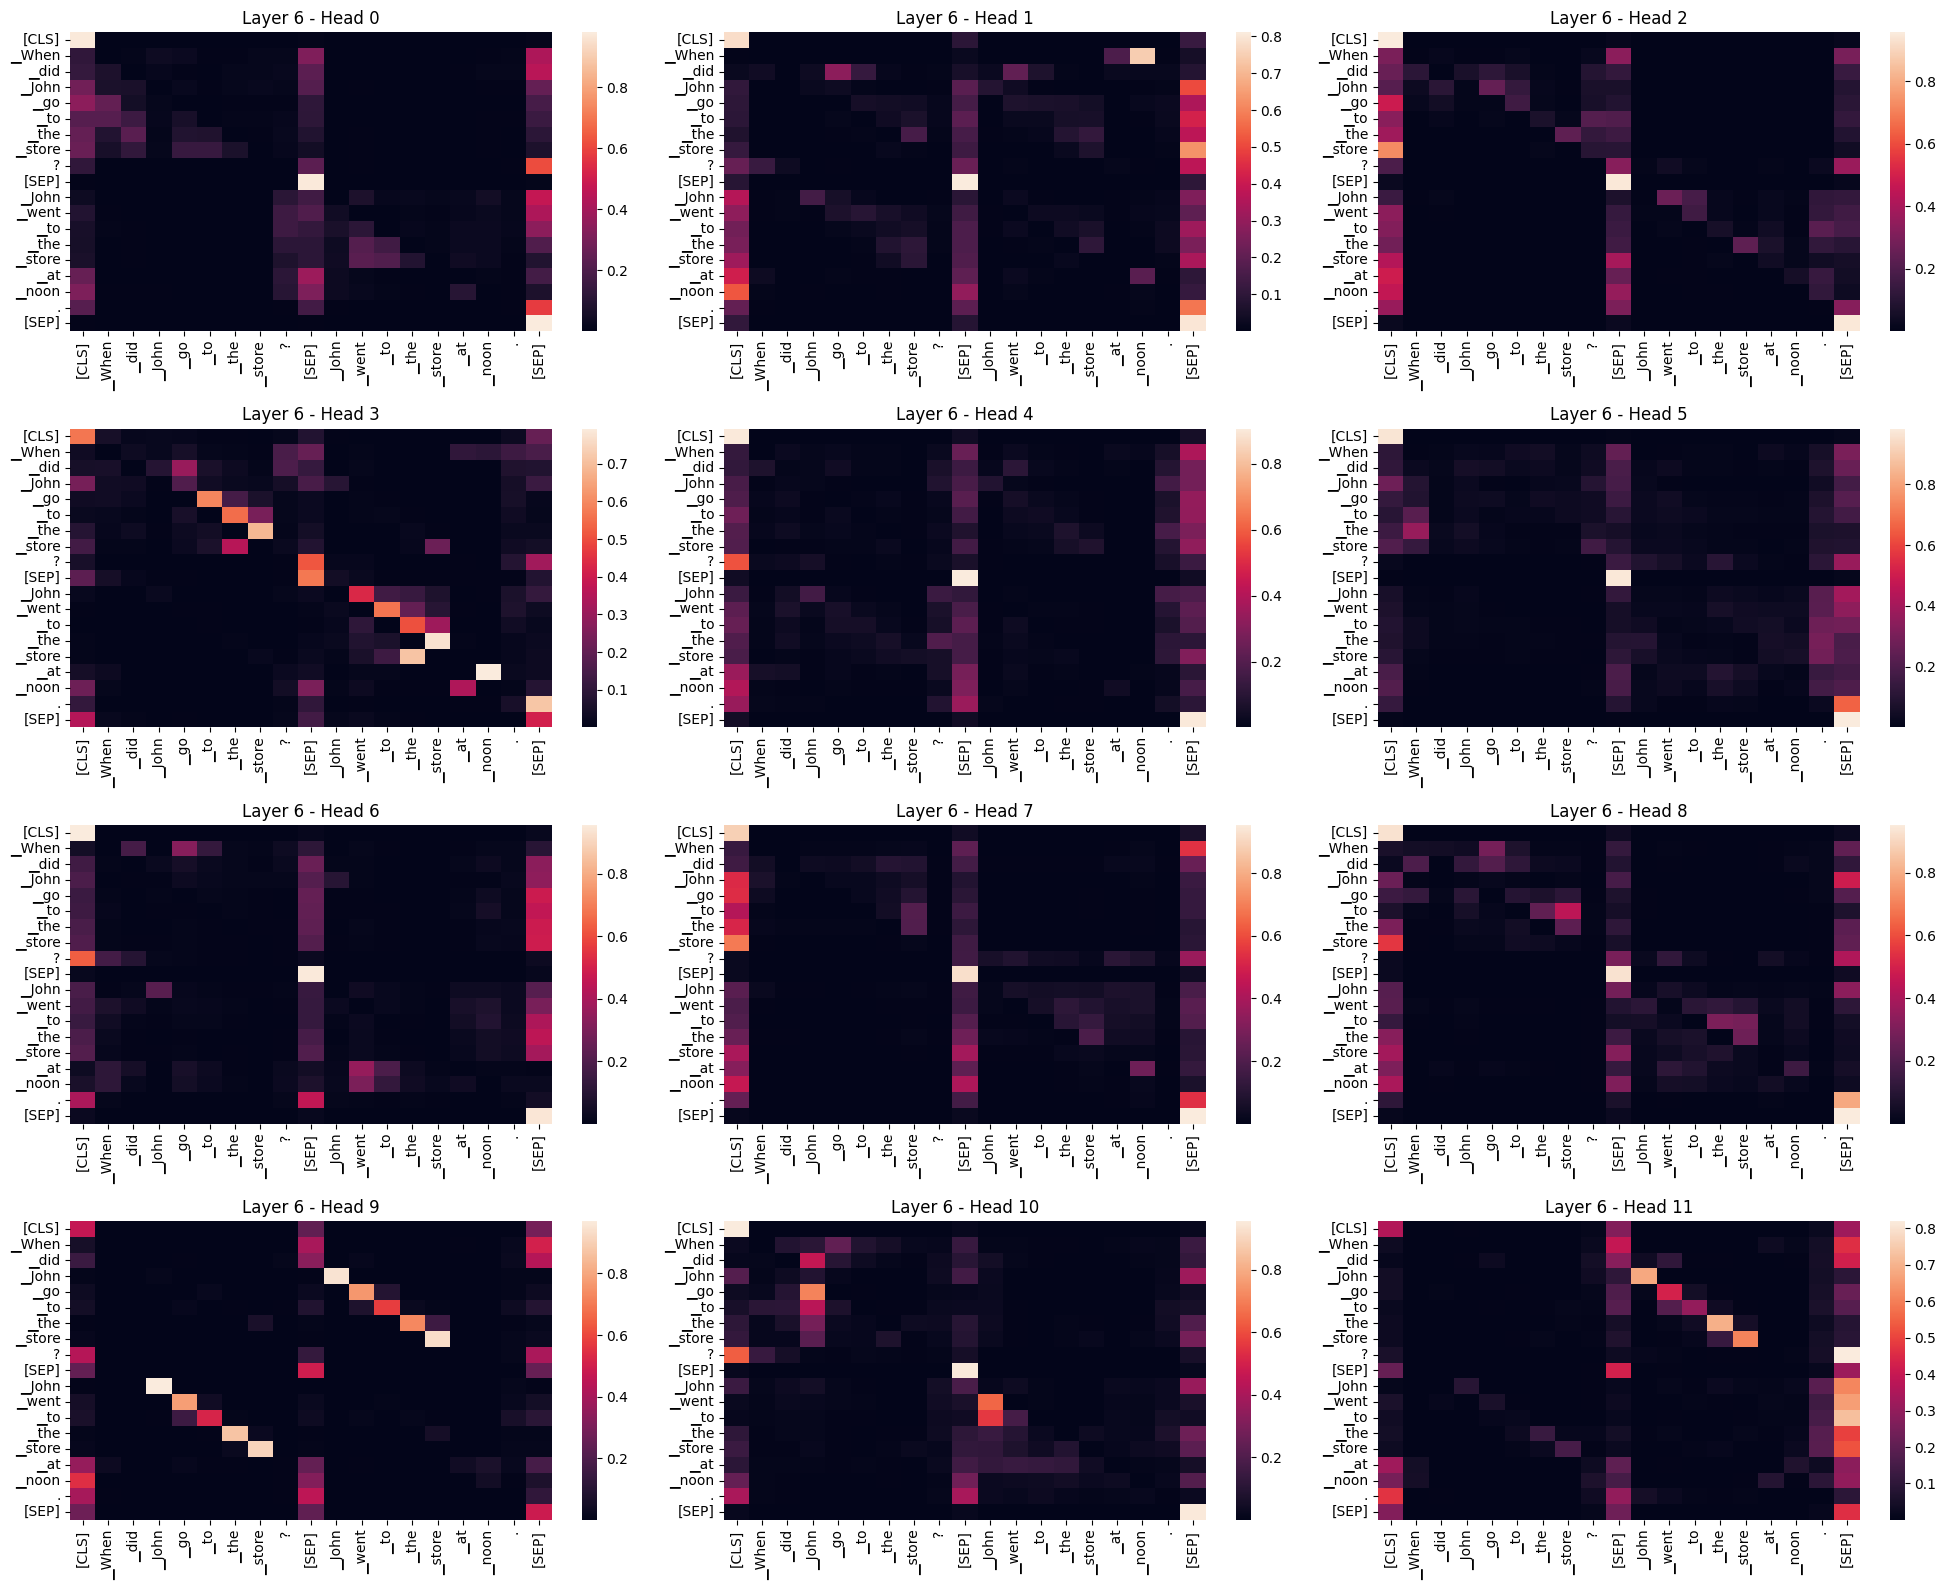

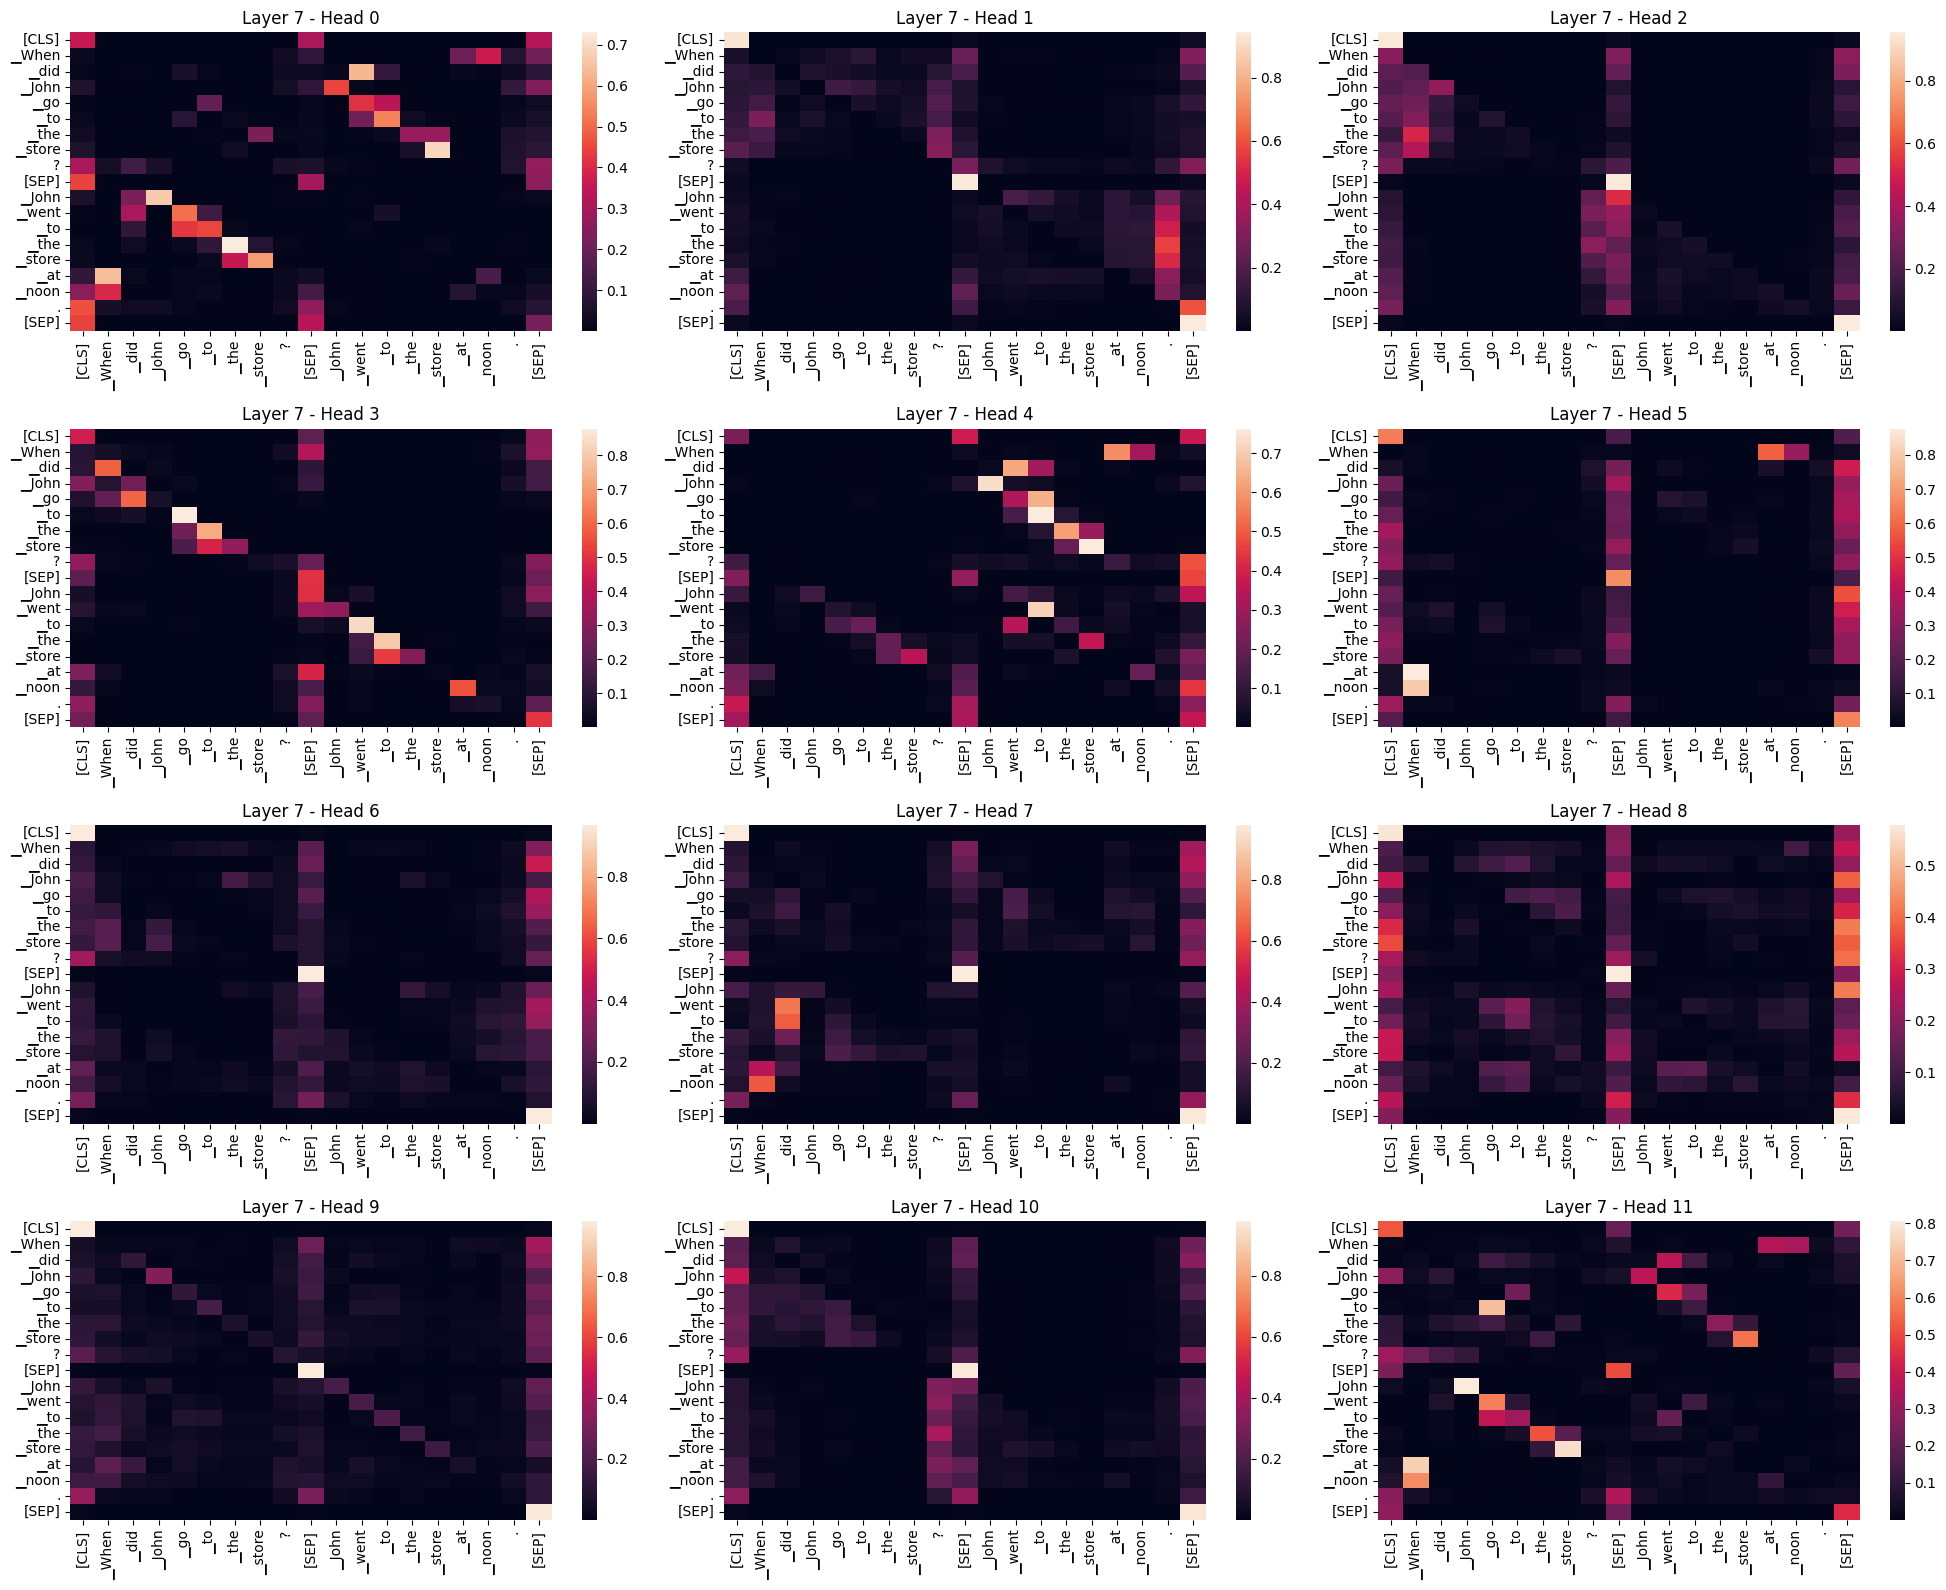

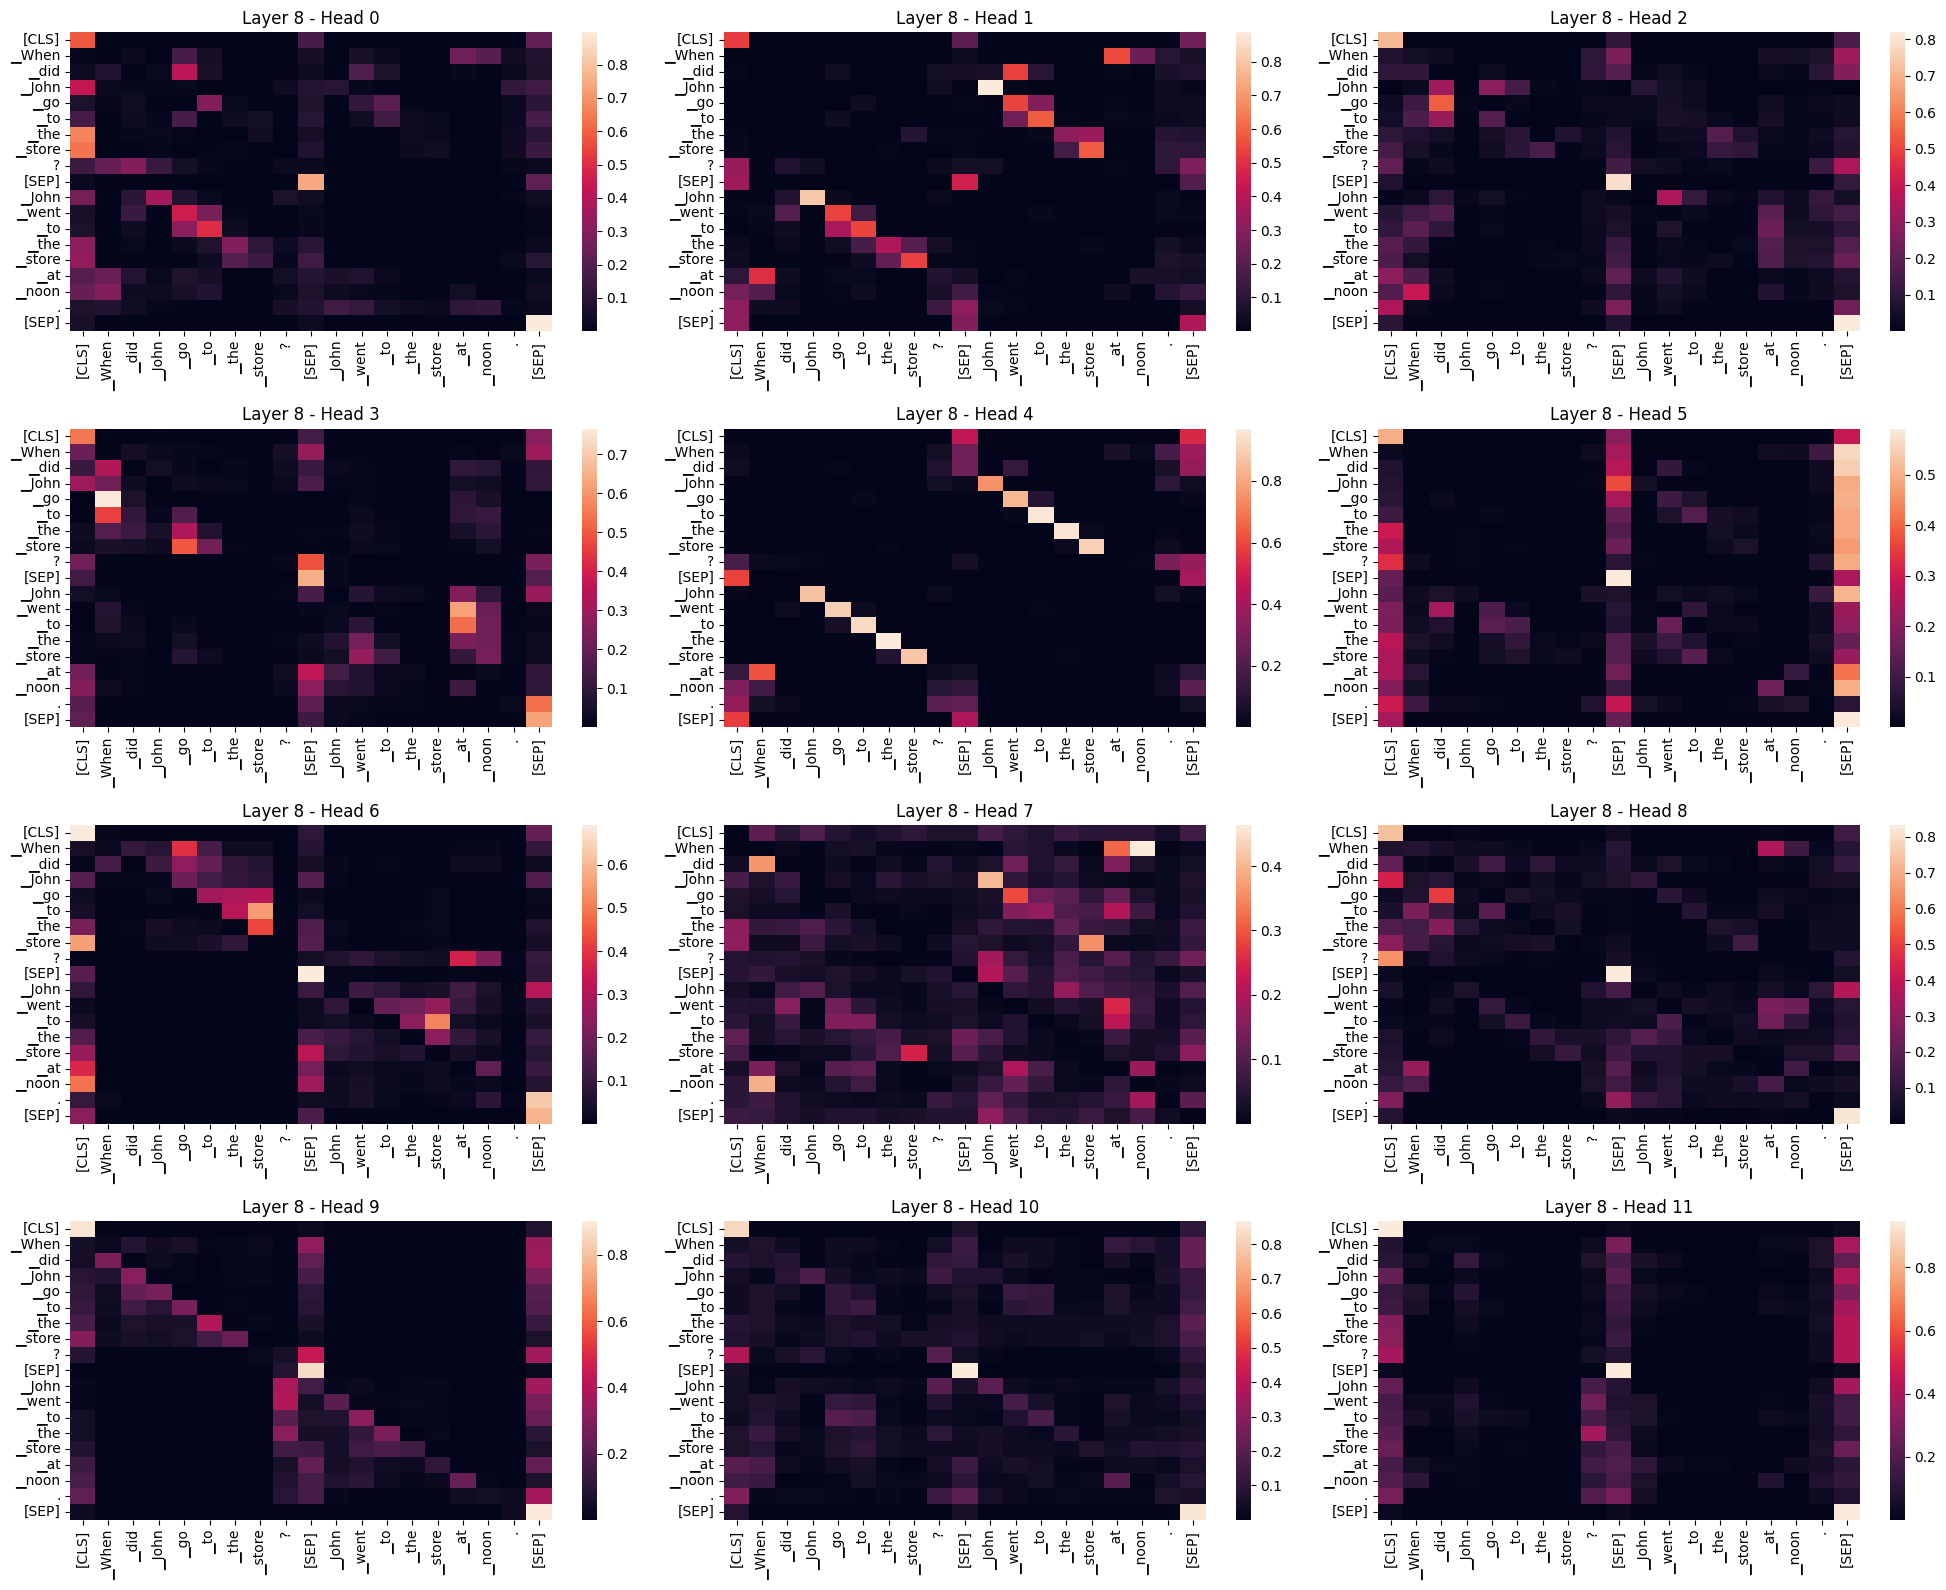

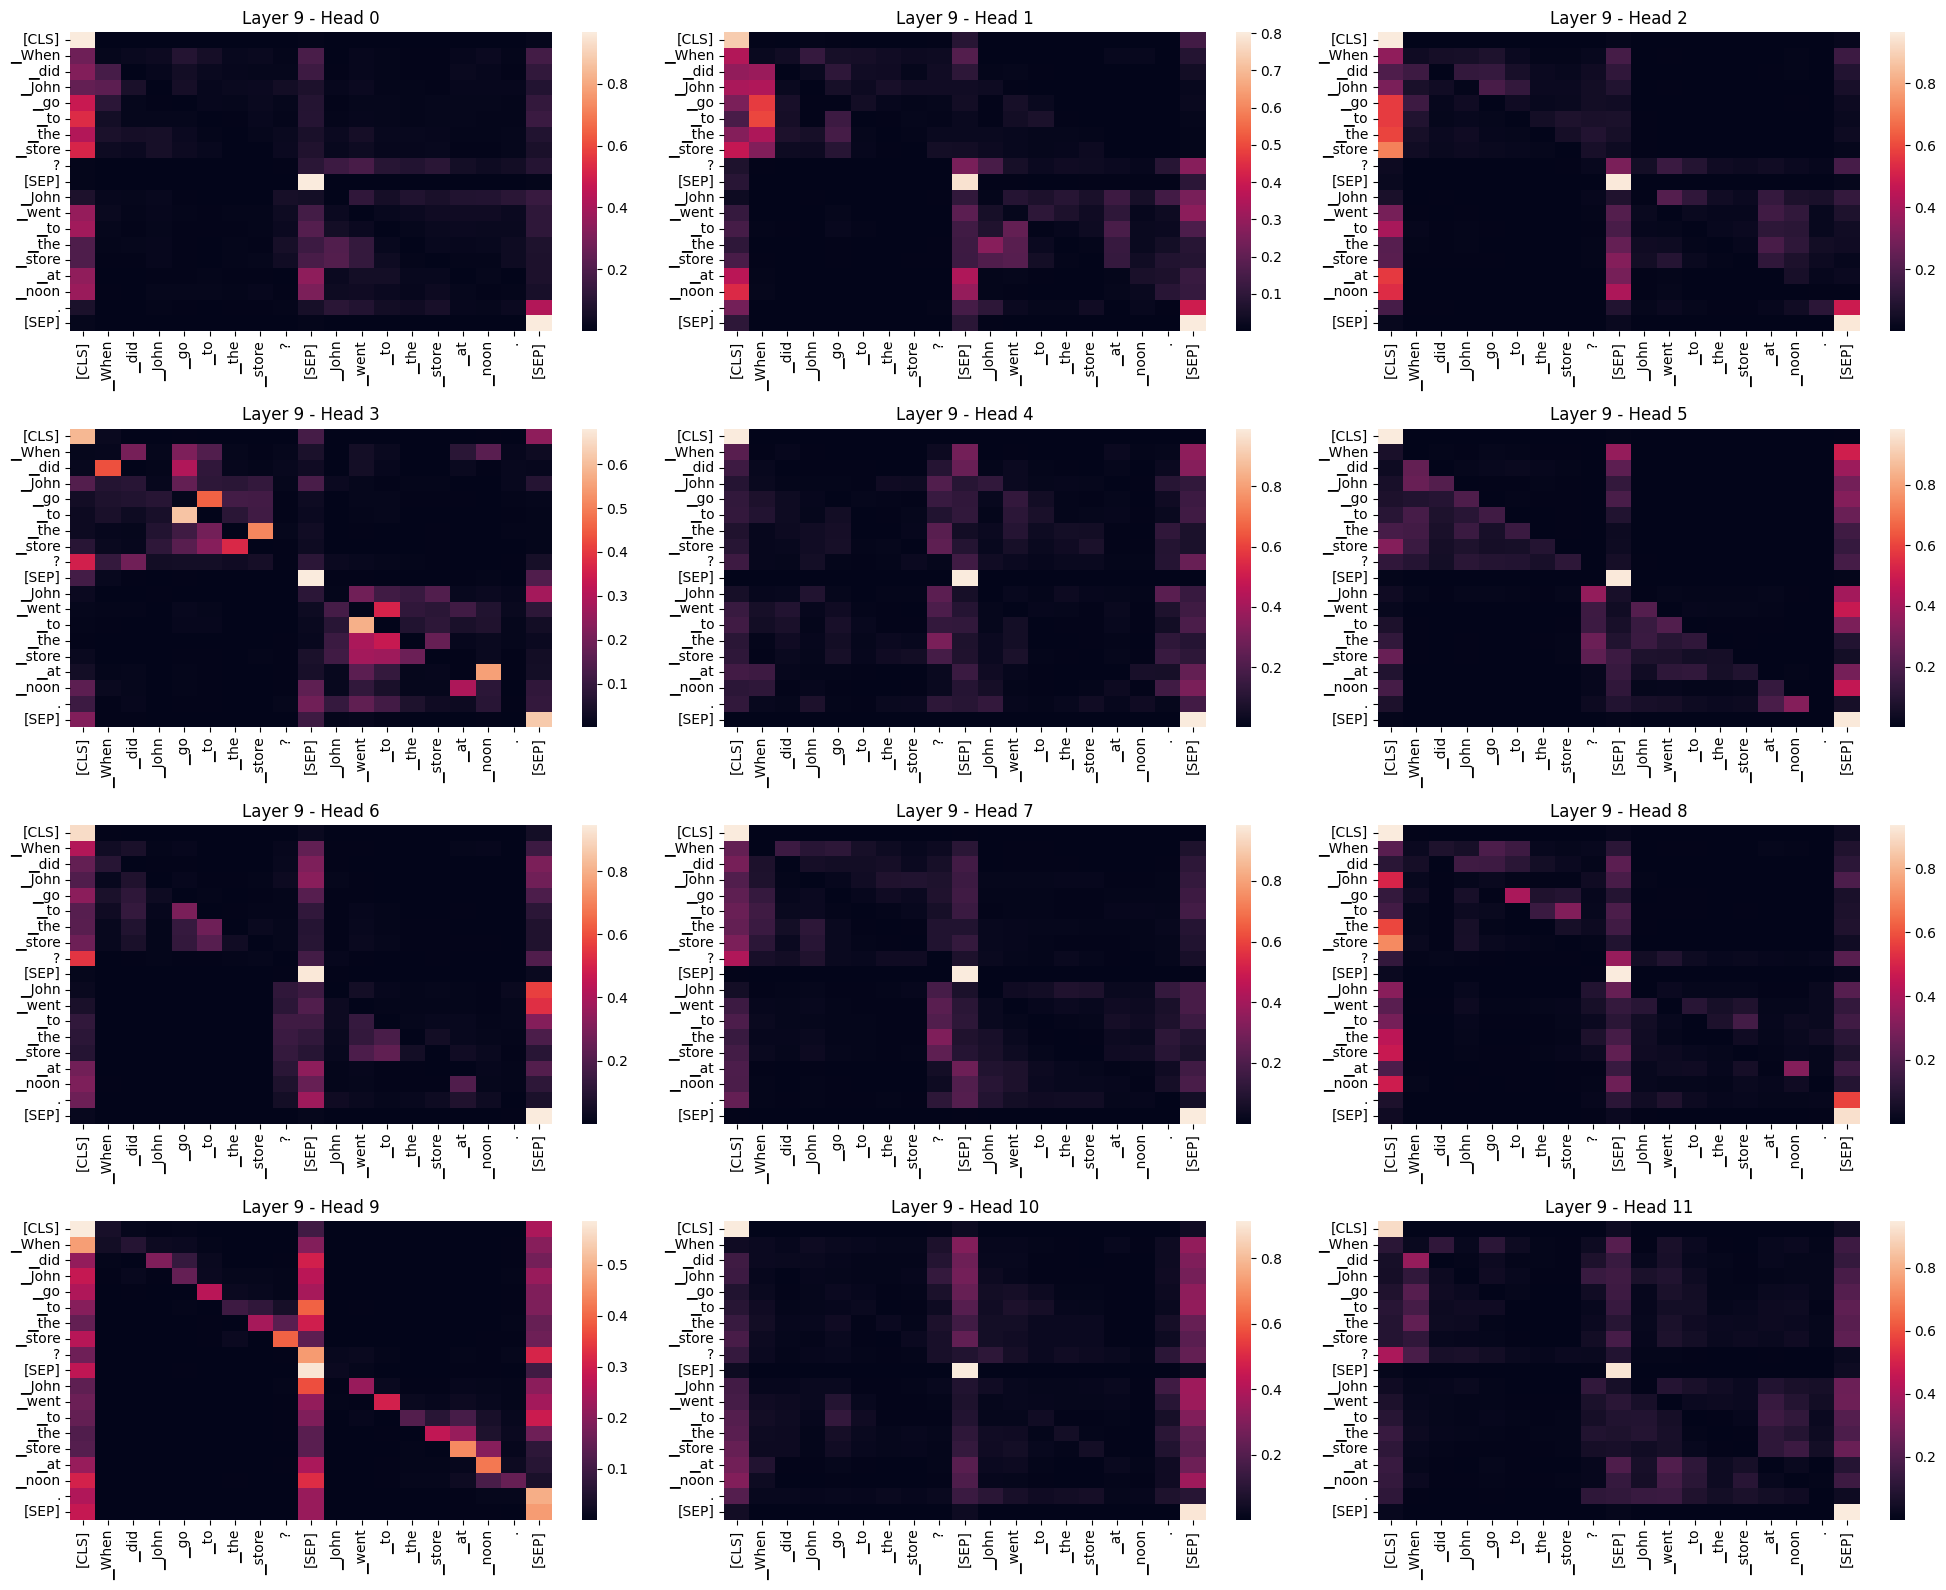

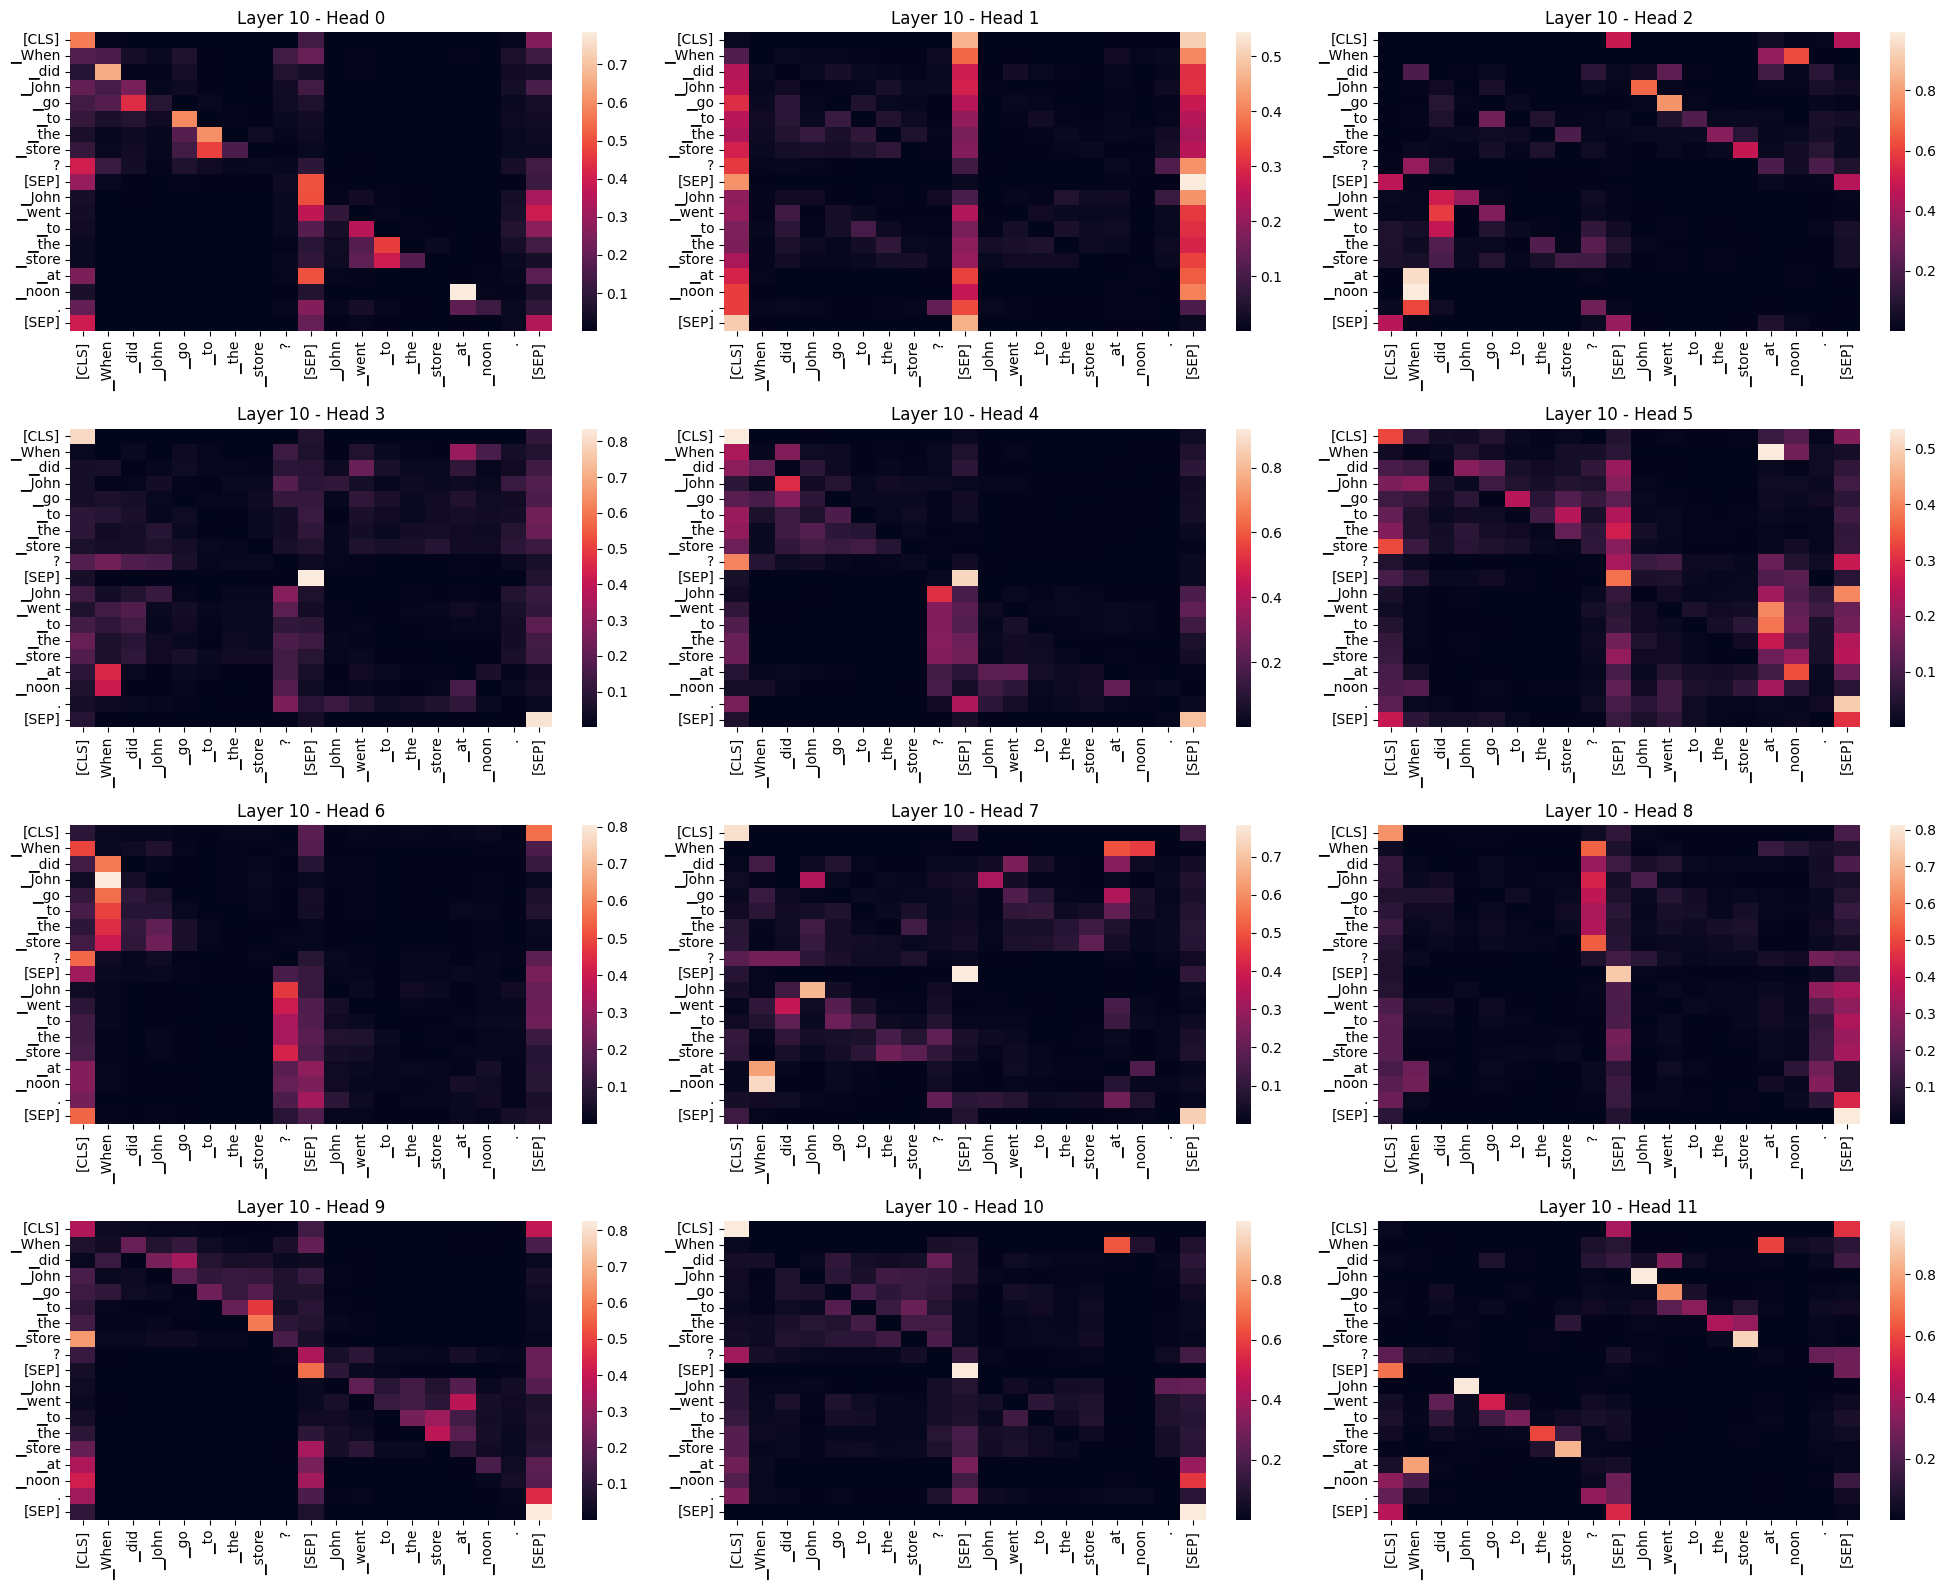

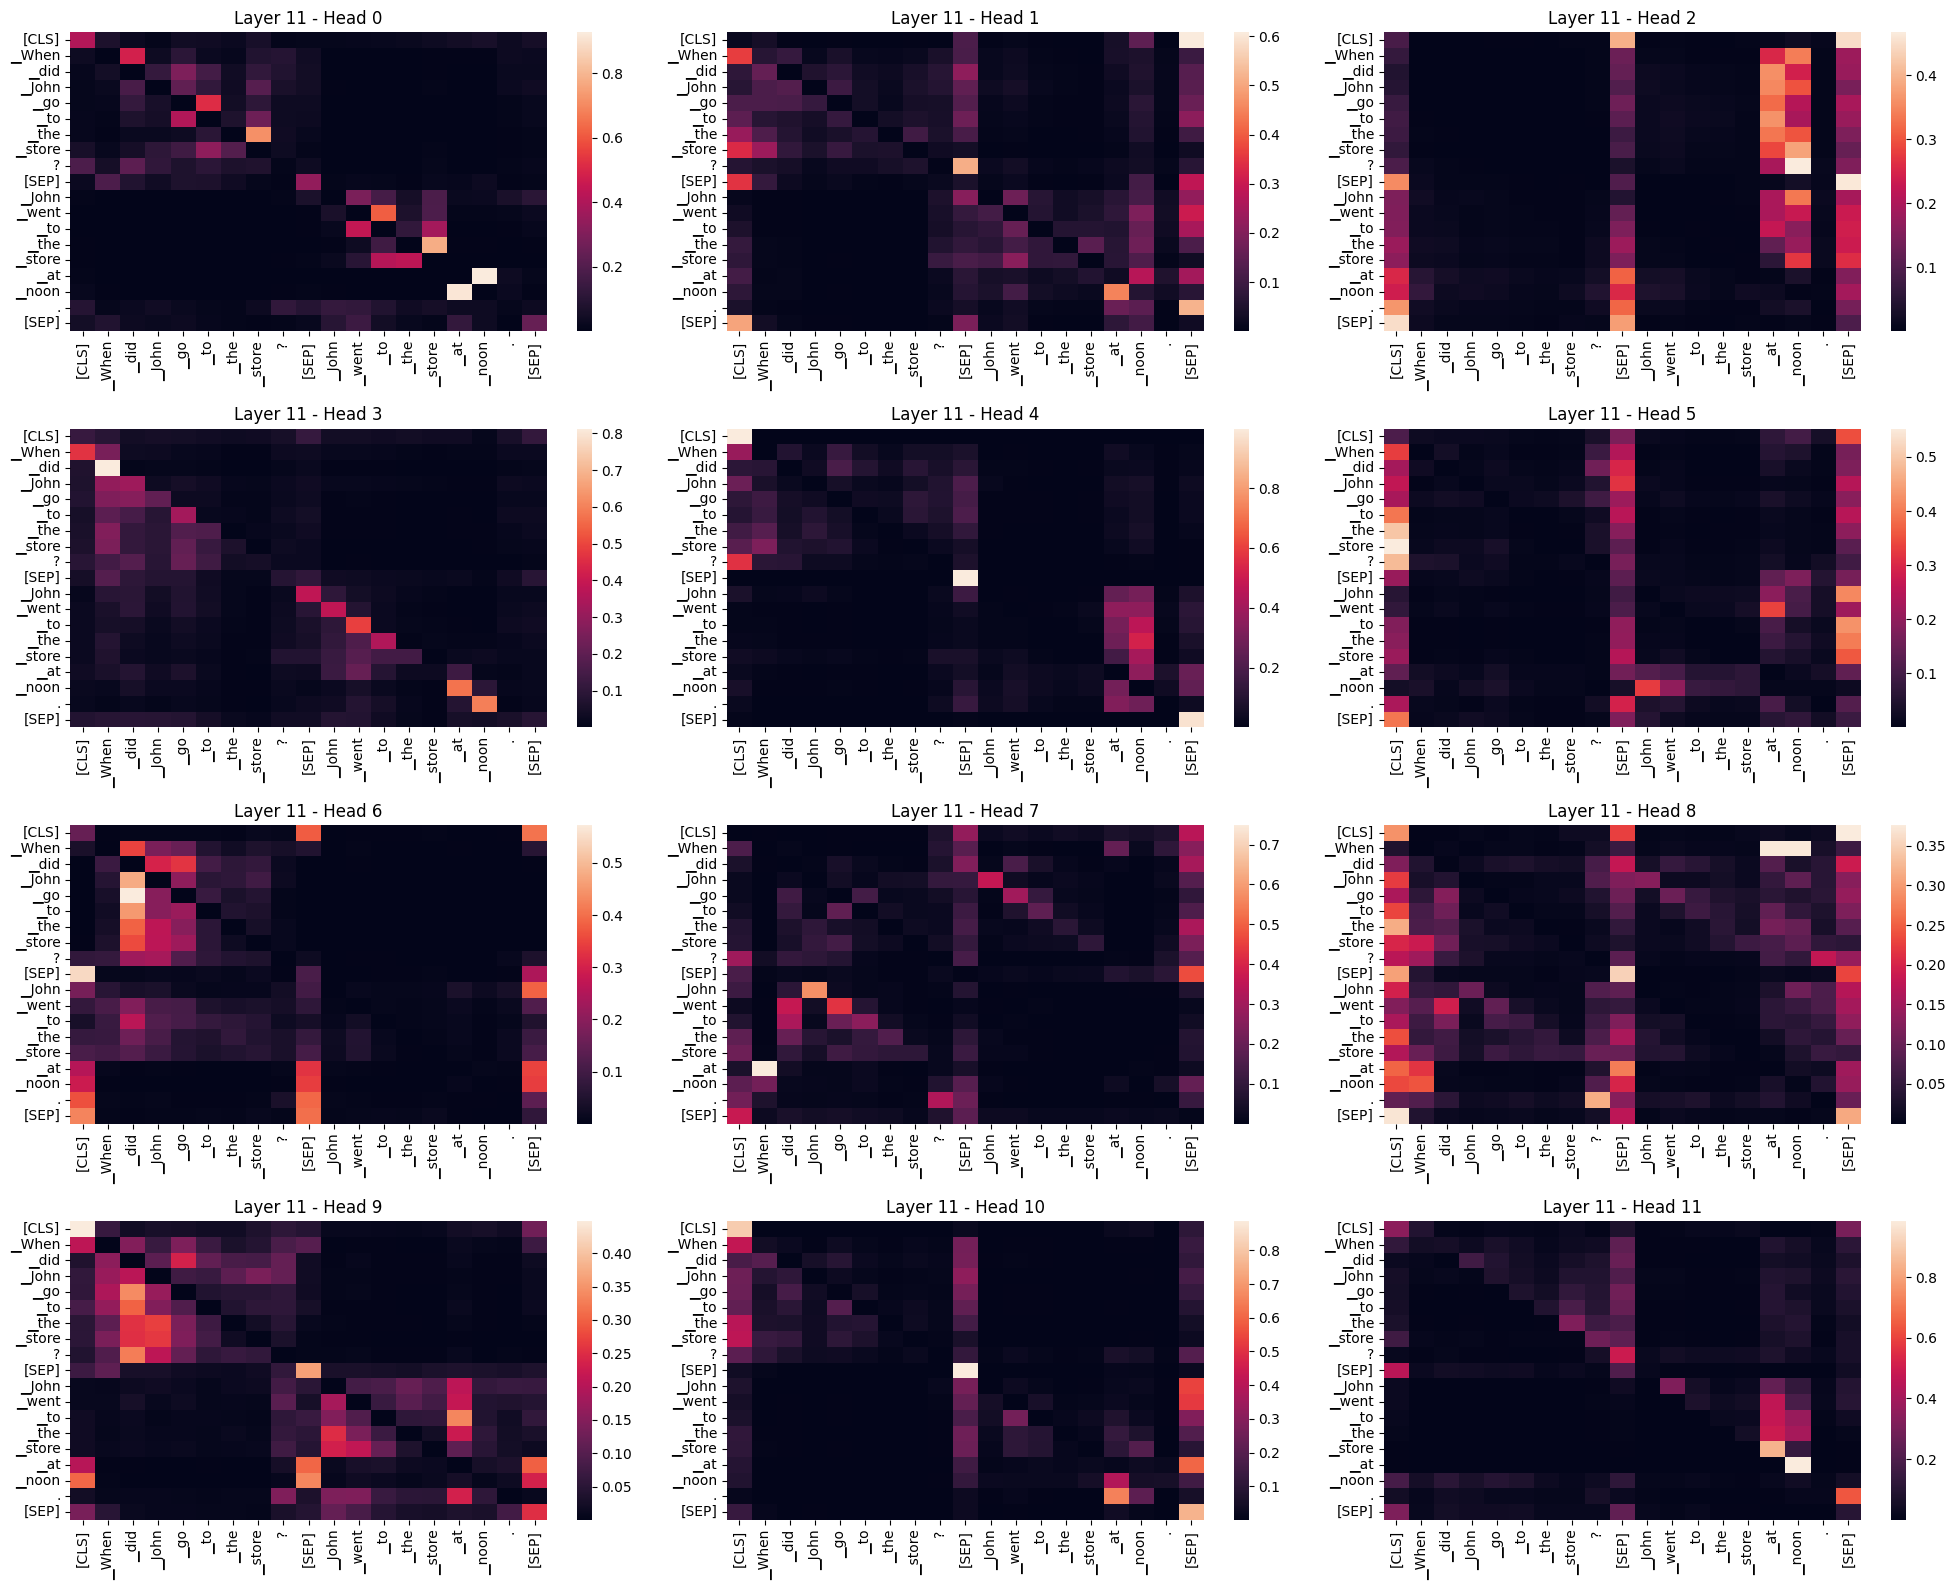

In [ ]:
import seaborn as sns

def plot_attention(attention, tokens, num_heads, layer_num):
    # Set the size of the entire grid
    plt.figure(figsize=(20, 16))
    for head in range(num_heads):
        attention_head = attention[head].detach().numpy()
        ax = plt.subplot(4, 3, head+1)  # 4x3 grid for 12 heads
        sns.heatmap(attention_head, xticklabels=tokens, yticklabels=tokens, ax=ax)
        ax.set_title(f'Layer {layer_num} - Head {head}')
    plt.tight_layout()
    plt.show()

for layer_num in range(len(attentions)):
  attention_matrix = attentions[layer_num]
  num_heads = attention_matrix.size(1)

  # Ensure the number of tokens matches the attention matrix size
  tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[:attention_matrix.size(-1)]

  plot_attention(attention_matrix[0], tokens, num_heads, layer_num)

context = "John went to the store at noon."
question = "When did John go to the store?"


    (When -> Noon)
    layer 6 head 1
    layer 7 head 4
    layer 8 head 5
    layer 10 head 5

    (When -> Noon and Noon -> When)
    layer 7 head 0
    layer 7 head 5
    layer 7 head 11
    layer 8 head 0
    layer 8 head 1
    layer 8 head 4
    layer 8 head 7
    layer 8 head 8
    layer 10 head 2
    layer 10 head 7
    layer 11 head 7